In [1]:
using Distributions
using Random
using Roots
using StatsPlots
default(fmt = :png, size = (640, 400),
    titlefontsize = 10, plot_titlefont = 10)

In [2]:
function confdist(m, x̄, sx²)
    SEhat = √(sx²/m)
    x̄ + SEhat * TDist(m - 1)
end

function confdist(x)
    m, x̄, sx² = length(x), mean(x), var(x)
    confdist(m, x̄, sx²)
end

function tvalue(m, x̄, sx², μ = 0.0)
    (x̄ - μ) / √(sx²/m)
end

function tvalue(x, μ = 0.0)
    m, x̄, sx² = length(x), mean(x), var(x)
    tvalue(m, x̄, sx², μ)
end

function pvalue(m, x̄, sx², μ = 0.0)
    t = tvalue(m, x̄, sx², μ)
    ν = m - 1
    2ccdf(TDist(ν), abs(t))
end

function pvalue(x, μ = 0.0)
    m, x̄, sx² = length(x), mean(x), var(x)
    pvalue(m, x̄, sx², μ)
end

function confint(m, x̄, sx²; α = 0.05)
    ν = m - 1
    c = quantile(TDist(ν), 1-α/2)
    SEhat = √(sx²/m)
    [x̄ - c*SEhat, x̄ + c*SEhat]
end

function confint(x; α = 0.05)
    m, x̄, sx² = length(x), mean(x), var(x)
    confint(m, x̄, sx²; α)
end

confint (generic function with 2 methods)

In [3]:
function dist_pred(m, x̄, sx²)
    SEhat = √(sx²*(1+1/m))
    x̄ + SEhat * TDist(m - 1)
end

function dist_pred(x)
    m, x̄, sx² = length(x), mean(x), var(x)
    dist_pred(m, x̄, sx²)
end

function tvalue_pred(m, x̄, sx², xnew)
    (x̄ - xnew) / √(sx²*(1+1/m))
end

function tvalue_pred(x, xnew)
    m, x̄, sx² = length(x), mean(x), var(x)
    tvalue_pred(m, x̄, sx², xnew)
end

function pvalue_pred(m, x̄, sx², xnew)
    t = tvalue_pred(m, x̄, sx², xnew)
    ν = m - 1
    2ccdf(TDist(ν), abs(t))
end

function pvalue_pred(x, xnew)
    m, x̄, sx² = length(x), mean(x), var(x)
    pvalue_pred(m, x̄, sx², xnew)
end

function predint(m, x̄, sx²; α = 0.05)
    ν = m - 1
    c = quantile(TDist(ν), 1-α/2)
    SEhat = √(sx²*(1+1/m))
    [x̄ - c*SEhat, x̄ + c*SEhat]
end

function predint(x; α = 0.05)
    m, x̄, sx² = length(x), mean(x), var(x)
    confint_pred(m, x̄, sx²; α)
end

predint (generic function with 2 methods)

In [4]:
function logmaxlik(x)
    mle = fit_mle(Normal, x)
    loglikelihood(mle, x)
end

function maxlik(x)
    exp(logmaxlik(x))
end

function conditional_mle(x, μ)
    s = std(x; mean = μ, corrected = false)
    Normal(μ, s)
end

function conditional_logmaxlik(x, μ)
    cmle = conditional_mle(x, μ)
    loglikelihood(cmle, x)
end

function conditional_maxlik(x, μ)
    exp(conditional_logmaxlik(x, μ))
end

function logmaxlikrat(x, μ)
    conditional_logmaxlik(x, μ) - logmaxlik(x)
end

function maxlikrat(x, μ)
    exp(logmaxlikrat(x, μ))
end

function neg2loglikrat(x, μ)
    -2logmaxlikrat(x, μ)
end

function pvalue_loglikrat(x, μ)
    ccdf(Chisq(1), neg2loglikrat(x, μ))
end

function confint_loglikrat(x; α = 0.05)
    c = quantile(Chisq(1), 1 - α)
    ci = confint(x; α = α/10)
    find_zeros(μ -> neg2loglikrat(x, μ) - c, ci...)
end

confint_loglikrat (generic function with 1 method)

In [5]:
logmaxlikrat2pvalue(lmlr) = ccdf(Chisq(1), -2lmlr)
maxlikrat2pvalue(mlr) = ccdf(Chisq(1), -2log(mlr))
pvalue2logmaxlikrat(pval) = -quantile(Chisq(1), 1 - pval)/2
pvalue2maxlikrat(pval) = exp(pvalue2logmaxlikrat(pval))

pvalue2maxlikrat (generic function with 1 method)

In [6]:
function baysian_update(x;
        μ₀ = 0, sμ² = 100^2, γ = 2, θ = 0.5,
        pri = (μ₀ = μ₀, λ₀ = 1/(γ*θ*(1 - 1/γ)*sμ²), γ, θ)
    )
    (; μ₀, λ₀, γ, θ) = pri
    m, x̄, s² = length(x), mean(x), var(x)
    μ₀_new = (λ₀*μ₀ + m*x̄)/(λ₀ + m)
    λ₀_new = λ₀ + m
    γ_new = γ + m/2
    θ_new = θ/(1 + θ/2*(m*λ₀/(λ₀ + m)*(x̄ - μ₀)^2 + (m - 1)*s²))
    post = (μ₀ = μ₀_new, λ₀ = λ₀_new, γ = γ_new, θ = θ_new)
end

function pdf_μλ(μ, λ;
        μ₀ = 0, sμ² = 100^2, γ = 2, θ = 0.5,
        pri = (μ₀ = μ₀, λ₀ = 1/(γ*θ*(1 - 1/γ)*sμ²), γ, θ)
    )
    (; μ₀, λ₀, γ, θ) = pri
    pdf(Normal(μ₀, 1/√(λ*λ₀)), μ) * pdf(Gamma(γ, θ), λ)
end

function dist_μ(;
        μ₀ = 0, sμ² = 100^2, γ = 2, θ = 0.5,
        pri = (μ₀ = μ₀, λ₀ = 1/(γ*θ*(1 - 1/γ)*sμ²), γ, θ)
    )
    (; μ₀, λ₀, γ, θ) = pri
    μ₀ + TDist(2γ)/√(λ₀*γ*θ)
end

function dist_λ(;
        μ₀ = 0, sμ² = 100^2, γ = 2, θ = 0.5,
        pri = (μ₀ = μ₀, λ₀ = 1/(γ*θ*(1 - 1/γ)*sμ²), γ, θ)
    )
    (; μ₀, λ₀, γ, θ) = pri
    Gamma(γ, θ)
end

function dist_x(; 
        μ₀ = 0, sμ² = 100^2, γ = 2, θ = 0.5,
        pri = (μ₀ = μ₀, λ₀ = 1/(γ*θ*(1 - 1/γ)*sμ²), γ, θ)
    )
    (; μ₀, λ₀, γ, θ) = pri
    μ₀ + TDist(2γ)*√((1 + 1/λ₀)/(γ*θ))
end

function rand_μλ(; 
        μ₀ = 0, sμ² = 100^2, γ = 2, θ = 0.5,
        pri = (μ₀ = μ₀, λ₀ = 1/(γ*θ*(1 - 1/γ)*sμ²), γ, θ)
    )
    (; μ₀, λ₀, γ, θ) = pri
    λ = rand(Gamma(γ, θ))
    μ = rand(Normal(μ₀, 1/√(λ*λ₀)))
    (μ, λ)
end

function rand_μλ(L; 
        μ₀ = 0, sμ² = 100^2, γ = 2, θ = 0.5,
        pri = (μ₀ = μ₀, λ₀ = 1/(γ*θ*(1 - 1/γ)*sμ²), γ, θ)
    )
    [rand_μλ(; pri) for _ in 1:L]
end

function pvalue_bayes(x, μ;
        μ₀ = 0, sμ² = 100^2, γ = 2, θ = 0.5,
        pri = (μ₀ = μ₀, λ₀ = 1/(γ*θ*(1 - 1/γ)*sμ²), γ, θ)
    )
    post = baysian_update(x; pri)
    post_μ = dist_μ(; pri=post)
    2ccdf(post_μ, mean(post_μ) + abs(μ - mean(post_μ)))
end

function credint(x; α = 0.05,
        μ₀ = 0, sμ² = 100^2, γ = 2, θ = 0.5,
        pri = (μ₀ = μ₀, λ₀ = 1/(γ*θ*(1 - 1/γ)*sμ²), γ, θ)
    )
    post = baysian_update(x; pri)
    post_μ = dist_μ(; pri=post)
    quantile.(post_μ, [α/2, 1-α/2])
end

credint (generic function with 1 method)

In [7]:
function plot_etc(;
        dist_true = Gamma(10, 1),
        m = 10,
        ms = 3,
        α = 0.05,
        μ₀ = 0, sμ² = 100^2, γ = 2, θ = 0.5,
        pri = (μ₀ = μ₀, λ₀ = 1/(γ*θ*(1 - 1/γ)*sμ²), γ, θ),
        seed = nothing
    )
    isnothing(seed) || Random.seed!(seed)
    x = rand(dist_true, m)
    
    @show mean(dist_true) var(dist_true)
    @show mean(x) var(x)
    flush(stdout)
    
    μ, σ = mean(dist_true), std(dist_true)
    a, b = max(minimum(dist_true), μ-3σ), min(maximum(dist_true), μ+6σ)
    
    plot(dist_true, a, b; label="true dist")
    h = pdf(dist_true, mode(dist_true))
    scatter!(x, fill(-0.05h, m); label="sample", ms, msc=:auto, alpha=0.5, c=:red)
    title!("true distribution and size-$m sample")
    plot!() |> display
    
    plot(μ₀ -> pvalue(x, μ₀), a, b; label="P-value function of t-test")
    scatter!(x, fill(-0.05, m); label="sample", ms, msc=:auto, alpha=0.5, c=:red)
    plot!(xguide="μ₀", ytick=0:0.05:1)
    title!("P-value function of hypothesis μ = μ₀ for size-$m sample")
    plot!() |> display
    
    plot(μ₀ -> pvalue_loglikrat(x, μ₀), a, b;
        label="P-value function of log max. lik. ratio test", c=2)
    scatter!(x, fill(-0.05, m); label="sample", ms, msc=:auto, alpha=0.5, c=:red)
    plot!(xguide="μ₀", ytick=0:0.05:1)
    title!("P-value function of hypothesis μ = μ₀ for size-$m sample")
    plot!() |> display
    
    plot(μ₀ -> pvalue(x, μ₀), a, b; label="P-value function of t-test")
    plot!(μ₀ -> pvalue_loglikrat(x, μ₀), a, b;
        label="P-value function of log max. lik. ratio test", c=2, ls=:dash)
    scatter!(x, fill(-0.05, m); label="sample", ms, msc=:auto, alpha=0.5, c=:red)
    plot!(xguide="μ₀", ytick=0:0.05:1)
    title!("P-value function of hypothesis μ = μ₀ for size-$m sample")
    plot!() |> display
    
    @show ci = confint(x; α)
    flush(stdout)

    plot(μ₀ -> pvalue(x, μ₀), a, b; label="P-value function of t-test")
    plot!(ci, fill(α, 2); label="$(100(1-α))% CI of μ", lw=3, c=:blue)
    scatter!(x, fill(-0.05, m); label="sample", ms, msc=:auto, alpha=0.5, c=:red)
    plot!(xguide="μ₀", ytick=0:0.05:1)
    title!("P-value function of hypothesis μ = μ₀ and \
        confidence interval for size-$m sample")
    plot!() |> display
    
    @show ci = confint_loglikrat(x; α)
    flush(stdout)

    plot(μ₀ -> pvalue_loglikrat(x, μ₀), a, b;
        label="P-value function of log max. lik. ratio test", c=2)
    plot!(ci, fill(α, 2); label="$(100(1-α))% CI of μ", lw=3, c=:magenta)
    scatter!(x, fill(-0.05, m); label="sample", ms, msc=:auto, alpha=0.5, c=:red)
    plot!(xguide="μ₀", ytick=0:0.05:1)
    title!("P-value function of hypothesis μ = μ₀ and \
        confidence interval for size-$m sample")
    plot!() |> display
    
    @show ci = confint_loglikrat(x; α)
    flush(stdout)

    plot(μ₀ -> maxlikrat(x, μ₀), a, b; label="maximum likelihood ratio function", c=2)
    c = quantile(Chisq(1), 1-α)
    plot!(ci, fill(exp(-c/2), 2); label="$(100(1-α))% CI of μ", lw=3, c=:magenta)
    scatter!(x, fill(-0.05, m); label="sample", ms=3, msc=:auto, alpha=0.5, c=:red)
    plot!(xguide="μ₀", ytick=0:0.05:1)
    title!("maximum likelihood ratio function of μ = μ₀ for size-$m sample")
    plot!() |> display
    
    plot(μ₀ -> pvalue2maxlikrat(pvalue(x, μ₀)), a, b;
        label="max. lik. rat. conversion of t-test P-value func.")
    plot!(μ₀ -> maxlikrat(x, μ₀), a, b;
        label="maximum likelihood ratio function", c=2, ls=:dash)
    scatter!(x, fill(-0.05, m);
        label="sample", ms, msc=:auto, alpha=0.5, c=:red)
    plot!(xguide="μ₀", ytick=0:0.05:1)
    title!("maximum likelihood ratio function of μ = μ₀ for size-$m sample")
    plot!() |> display
    
    @show pri
    μλ = rand_μλ(10^5; pri)
    μσ² = [(μ, 1/λ) for (μ, λ) in μλ]
    μ, σ² = first.(μσ²), last.(μσ²)
    @show mean(μ), mean(σ²)
    xlim = quantile.(Ref(μ), (0.001, 0.999))
    ylim = quantile.(Ref(σ²), (0.001, 0.999))
    flush(stdout)

    scatter(μσ²; label="", ms=1, msc=:auto, alpha=0.1)
    plot!(xguide="μ", yguide="σ²")
    plot!(; xlim, ylim, yscale=:log10)
    title!("prior of (μ, σ²)")
    plot!() |> display
    
    @show post = baysian_update(x; pri)
    μλ = rand_μλ(10^4; pri=post)
    μσ² = [(μ, 1/λ) for (μ, λ) in μλ]
    μ, σ² = first.(μσ²), last.(μσ²)
    @show mean(μ), mean(σ²)
    xlim = quantile.(Ref(μ), (0.001, 0.999))
    ylim = quantile.(Ref(σ²), (0.001, 0.999))
    flush(stdout)
    
    scatter(μσ²; label="", ms=1, msc=:auto, alpha=0.3)
    plot!(xguide="μ", yguide="σ²")
    plot!(; xlim, ylim, yscale=:log10)
    title!("posterior of (μ, σ²) for size-$m sample")
    plot!() |> display
    
    @show post_μ = dist_μ(; pri=post)
    @show ci = credint(x; α, pri)
    flush(stdout)
    
    plot(post_μ, a, b; label="posterior")
    c = pdf(post_μ, mode(post_μ))
    plot!(μ₀ -> c*maxlikrat(x, μ₀), a, b;
        label="normalized maximum likelihood ratio function",
        c=2, ls=:dash)
    scatter!(x, fill(-0.05c, 2); label="sample",
        ms, msc=:auto, alpha=0.5, c=:red)
    title!("posterior pdf function of μ for size-$m sample")
    plot!() |> display
end

plot_etc (generic function with 1 method)

mean(dist_true) = 10.0
var(dist_true) = 10.0
mean(x) = 9.560365886166755
var(x) = 9.102142426957071


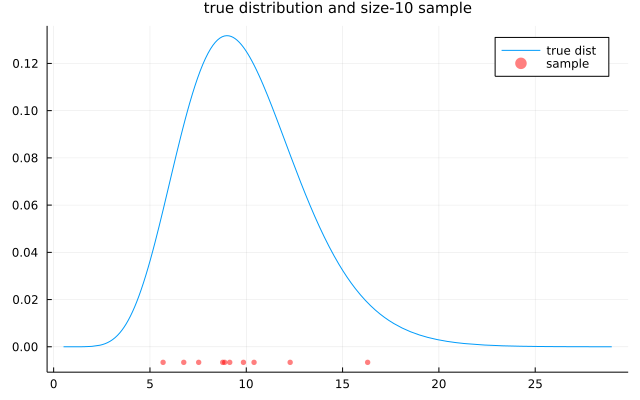

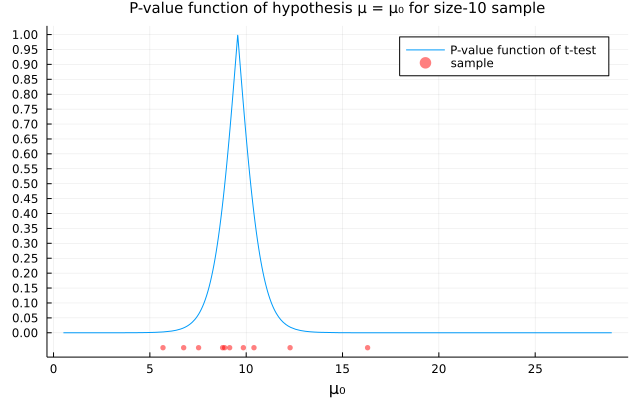

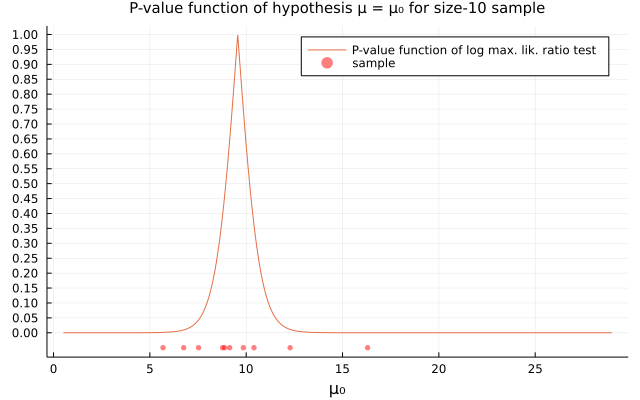

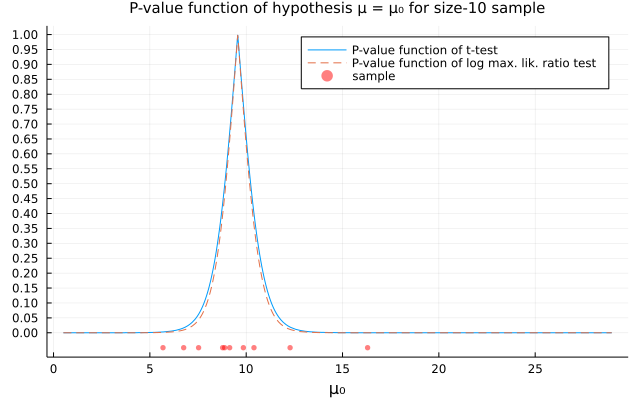

ci = confint(x; α) = [7.402151477794028, 11.718580294539482]


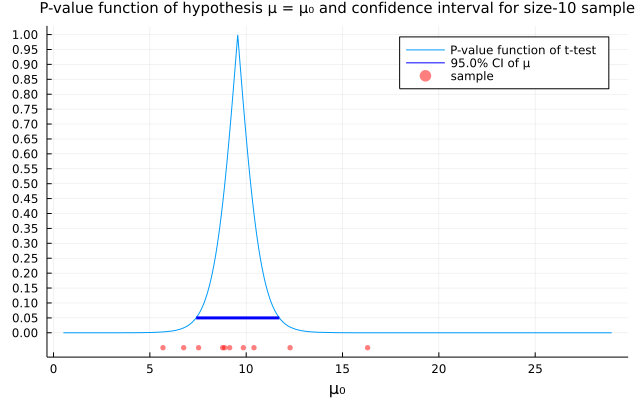

ci = confint_loglikrat(x; α) = [7.601598804244693, 11.519132968088815]


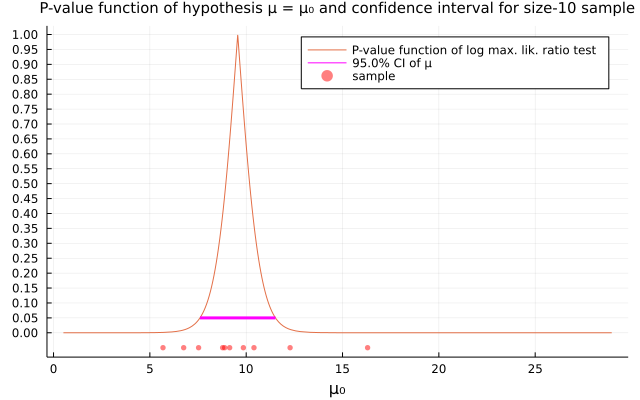

ci = confint_loglikrat(x; α) = [7.601598804244693, 11.519132968088815]


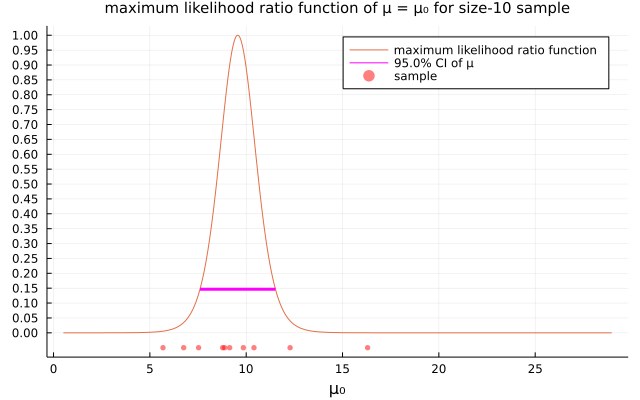

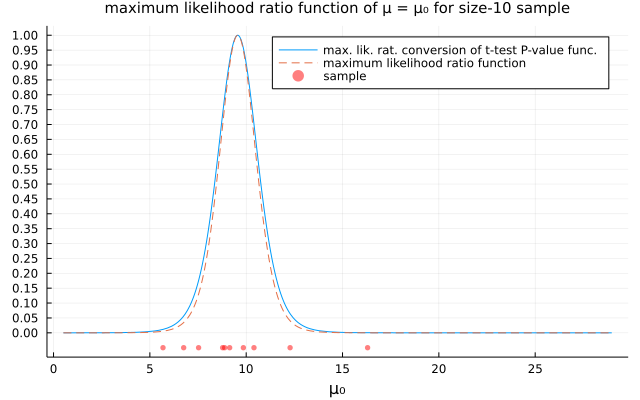

pri = (μ₀ = 0, λ₀ = 0.0002, γ = 2, θ = 0.5)
(mean(μ), mean(σ²)) = (-0.021935332568067296, 1.9929978604582133)


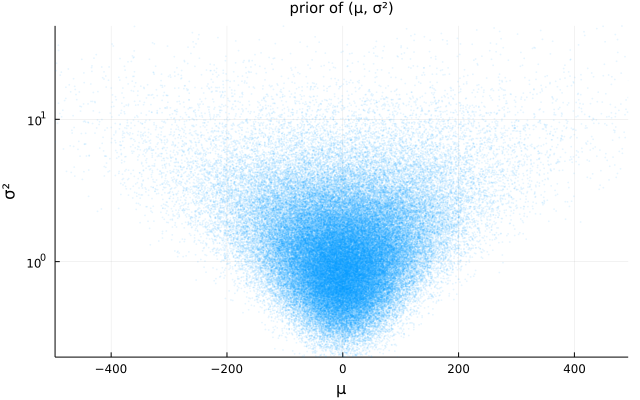

post = baysian_update(x; pri) = (μ₀ = 9.560174682673102, λ₀ = 10.0002, γ = 7.0, θ = 0.02327271059187901)
(mean(μ), mean(σ²)) = (9.553084965863077, 7.197049967561479)


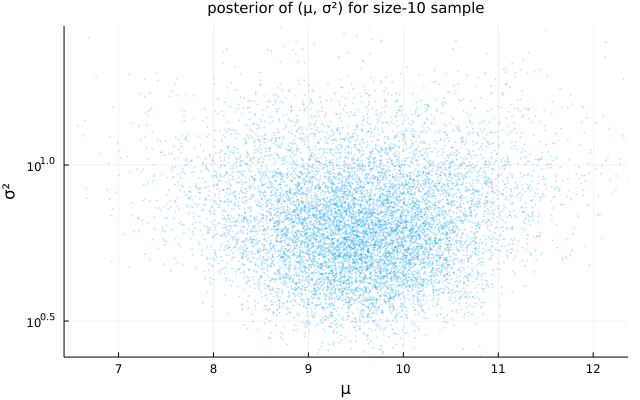

post_μ = dist_μ(; pri = post) = LocationScale{Float64, Continuous, TDist{Float64}}(
μ: 9.560174682673102
σ: 0.7834714092665525
ρ: TDist{Float64}(ν=14.0)
)

ci = credint(x; α, pri) = [7.879795633713998, 11.240553731632206]


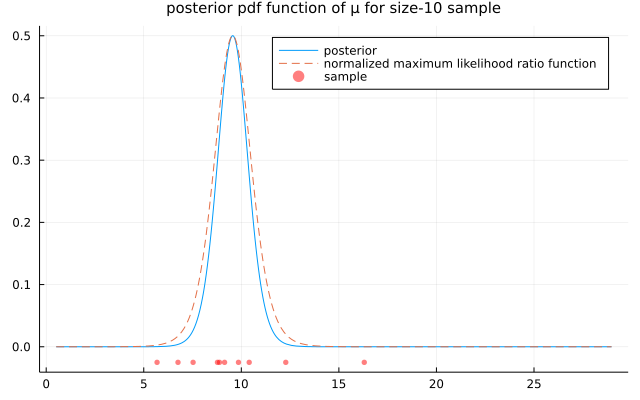

In [8]:
plot_etc(; dist_true=Gamma(10, 1), m=10, ms=3, seed=4649373)

mean(dist_true) = 10.0
var(dist_true) = 10.0
mean(x) = 9.169403594454309
var(x) = 6.925622020000762


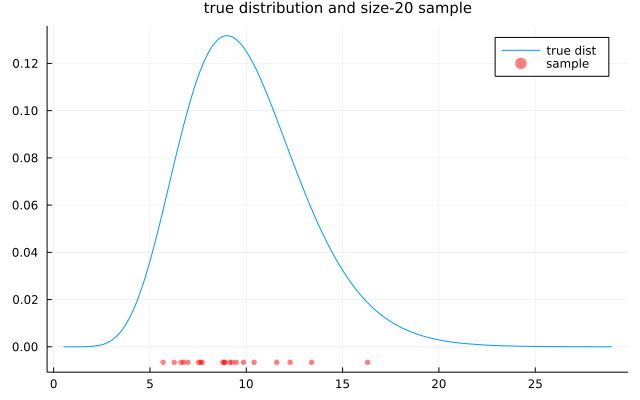

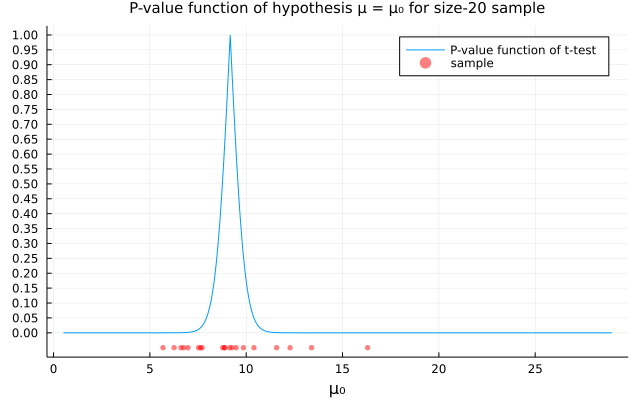

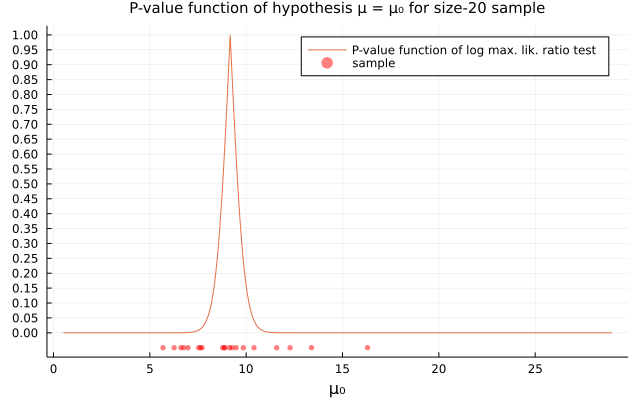

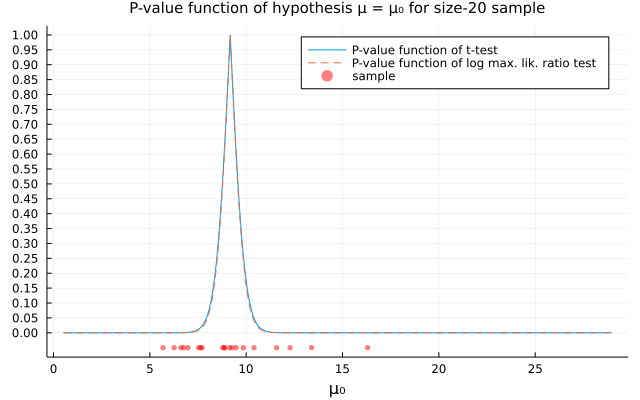

ci = confint(x; α) = [7.937749898537216, 10.401057290371401]


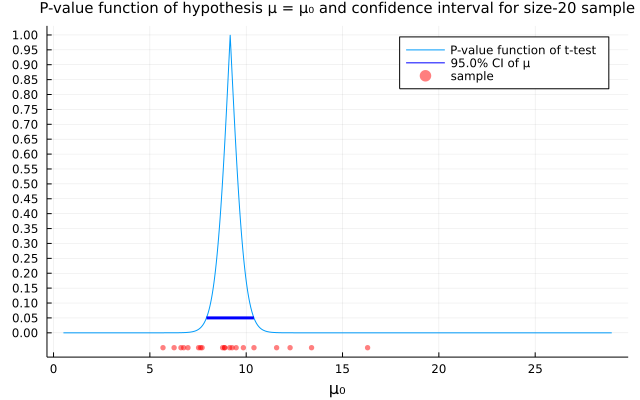

ci = confint_loglikrat(x; α) = [7.989050257411121, 10.349756931497492]


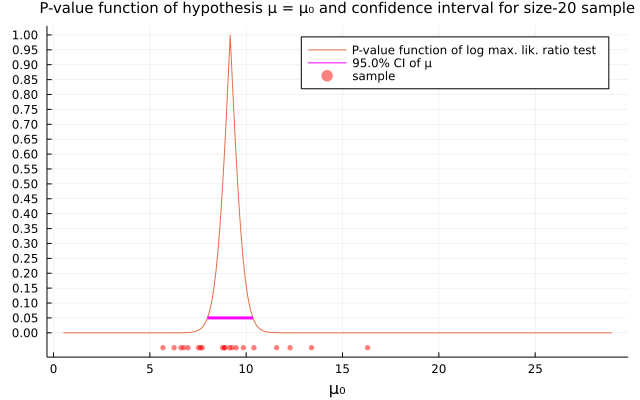

ci = confint_loglikrat(x; α) = [7.989050257411121, 10.349756931497492]


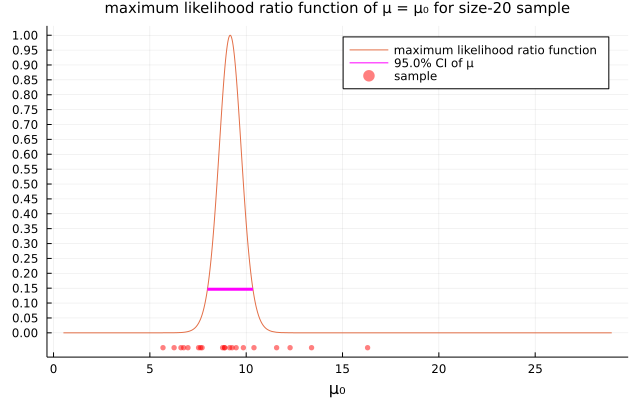

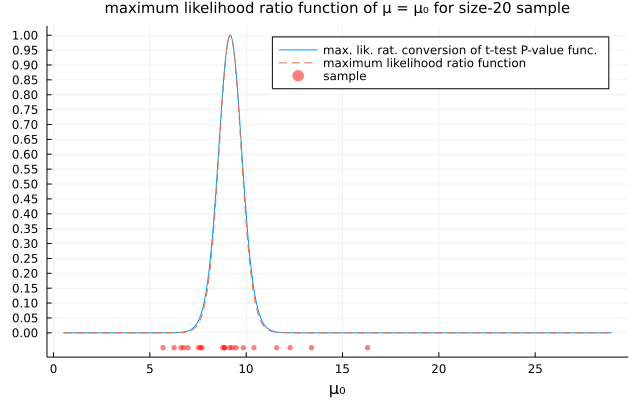

pri = (μ₀ = 0, λ₀ = 0.0002, γ = 2, θ = 0.5)
(mean(μ), mean(σ²)) = (-0.02194620274421578, 1.9930275379749947)


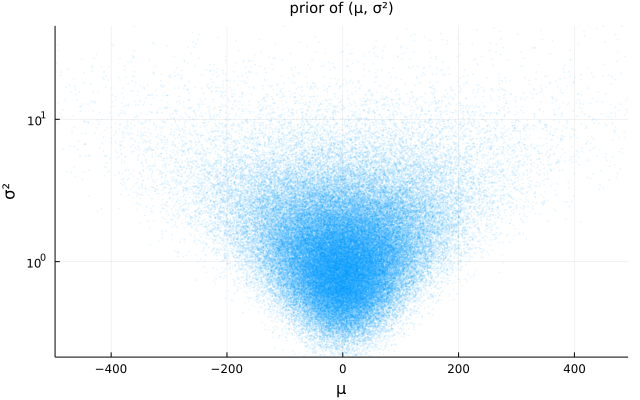

post = baysian_update(x; pri) = (μ₀ = 9.169311901335295, λ₀ = 20.0002, γ = 12.0, θ = 0.014748867297215059)
(mean(μ), mean(σ²)) = (9.166136142582653, 6.182271309345299)


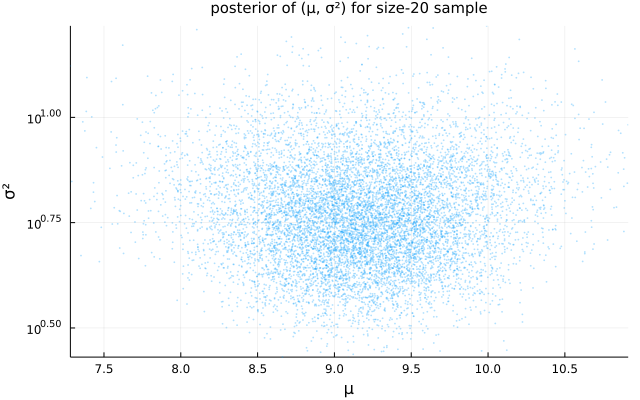

post_μ = dist_μ(; pri = post) = LocationScale{Float64, Continuous, TDist{Float64}}(
μ: 9.169311901335295
σ: 0.531511754694291
ρ: TDist{Float64}(ν=24.0)
)

ci = credint(x; α, pri) = [8.072325555333359, 10.26629824733723]


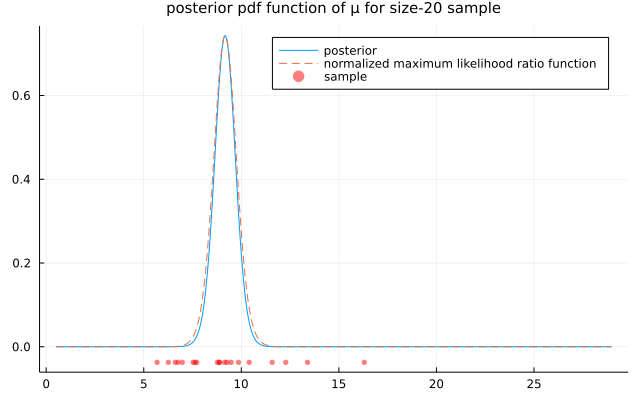

In [9]:
plot_etc(; dist_true=Gamma(10, 1), m=20, ms=3, seed=4649373)

mean(dist_true) = 10.0
var(dist_true) = 10.0
mean(x) = 9.031727755767667
var(x) = 7.009850017505368


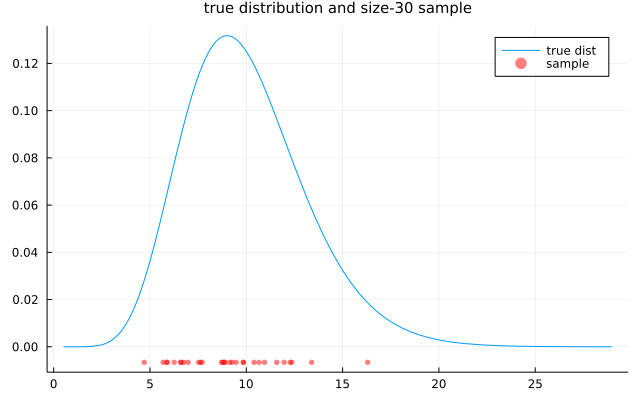

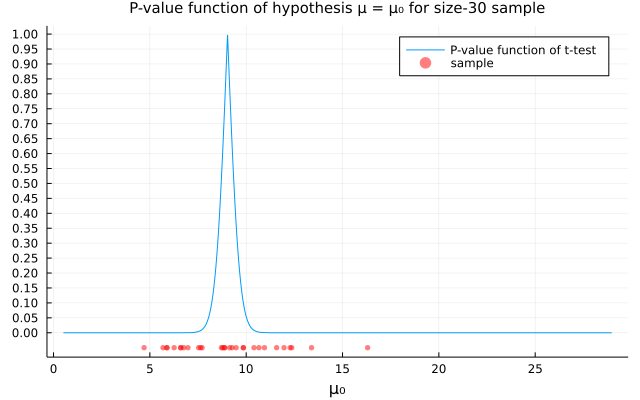

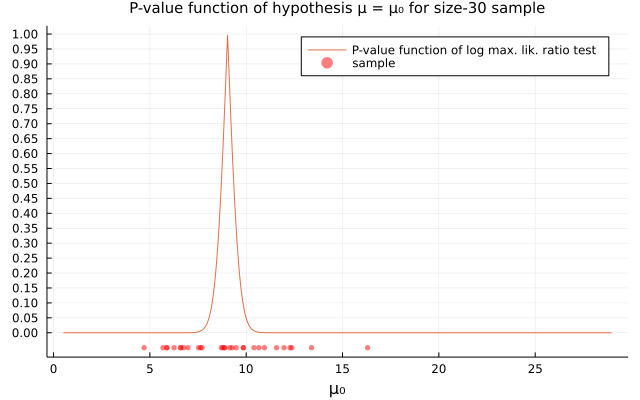

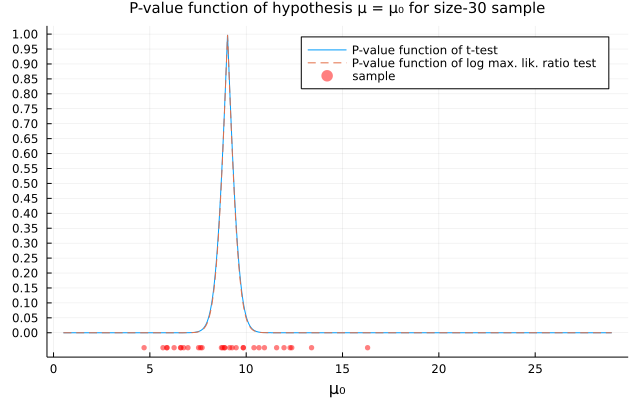

ci = confint(x; α) = [8.043093136795969, 10.020362374739365]


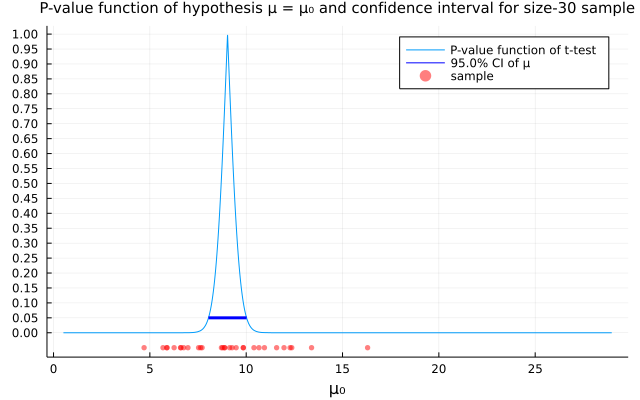

ci = confint_loglikrat(x; α) = [8.069603346647728, 9.993852164887597]


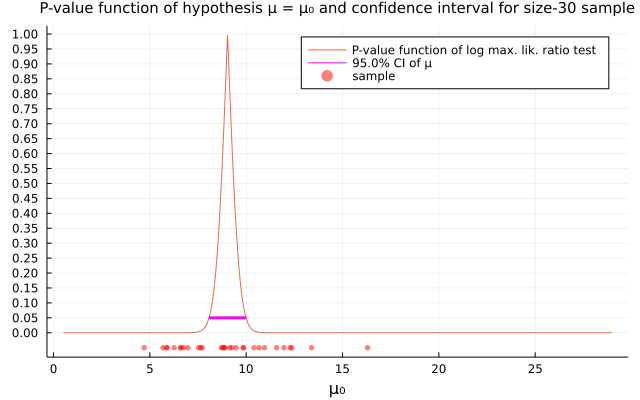

ci = confint_loglikrat(x; α) = [8.069603346647728, 9.993852164887597]


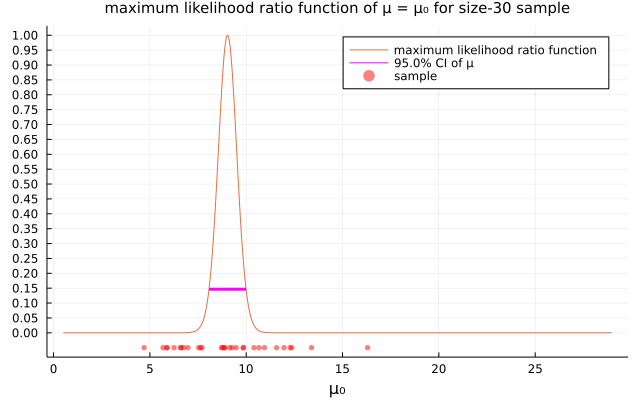

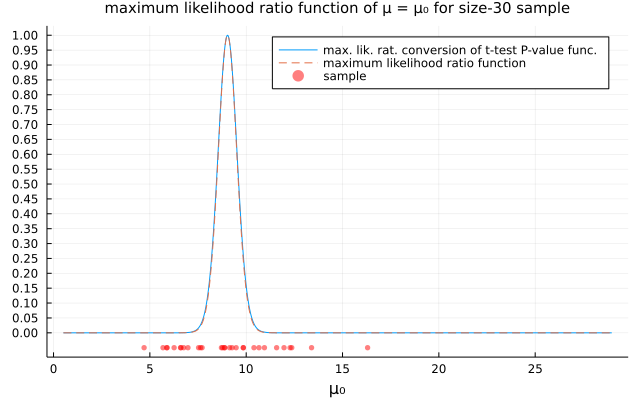

pri = (μ₀ = 0, λ₀ = 0.0002, γ = 2, θ = 0.5)
(mean(μ), mean(σ²)) = (-0.015676406250924955, 1.9932504278978114)


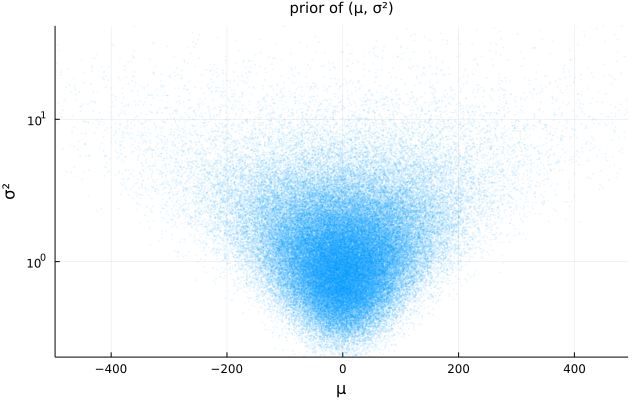

post = baysian_update(x; pri) = (μ₀ = 9.031667544650704, λ₀ = 30.0002, γ = 17.0, θ = 0.00964776190971081)
(mean(μ), mean(σ²)) = (9.029327644487502, 6.491678482079427)


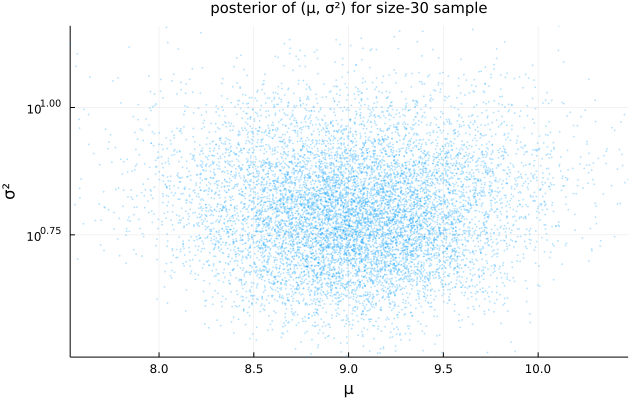

post_μ = dist_μ(; pri = post) = LocationScale{Float64, Continuous, TDist{Float64}}(
μ: 9.031667544650704
σ: 0.4508168868910483
ρ: TDist{Float64}(ν=34.0)
)

ci = credint(x; α, pri) = [8.115497401558663, 9.947837687742744]


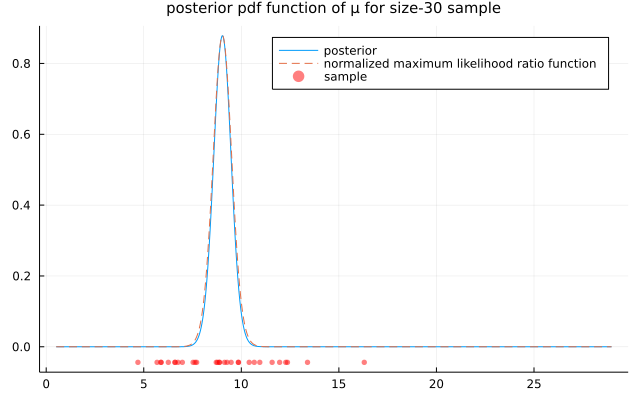

In [10]:
plot_etc(; dist_true=Gamma(10, 1), m=30, ms=3, seed=4649373)

mean(dist_true) = 10.0
var(dist_true) = 10.0
mean(x) = 9.579496676858493
var(x) = 9.648827100253905


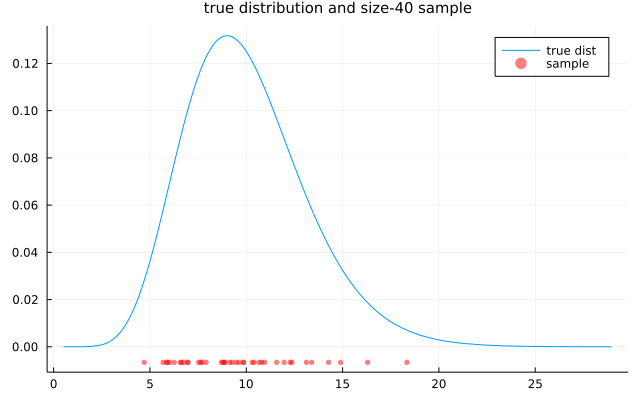

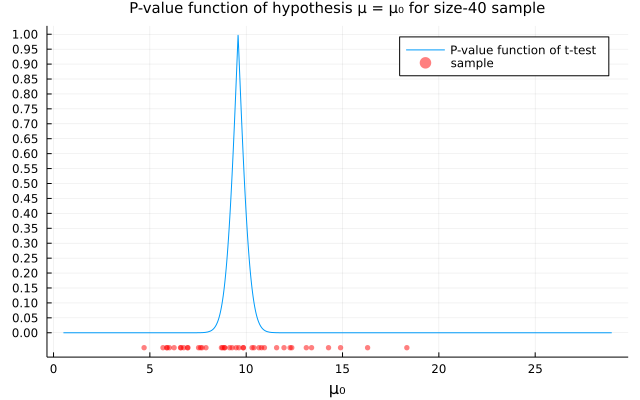

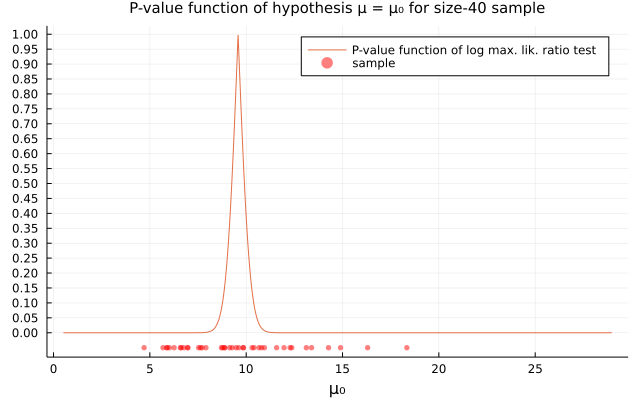

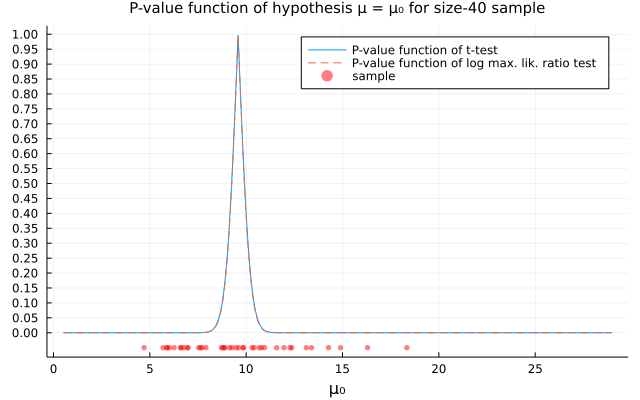

ci = confint(x; α) = [8.586067773701478, 10.572925580015509]


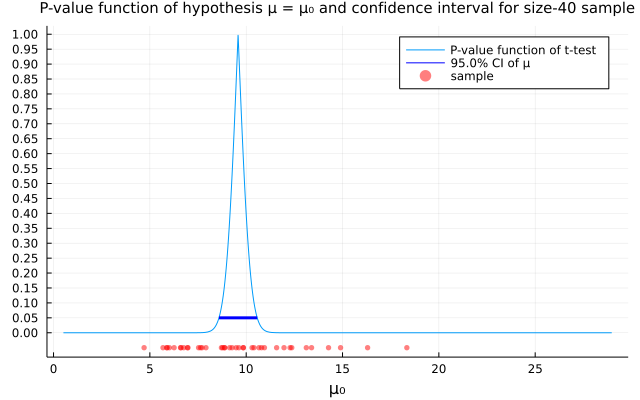

ci = confint_loglikrat(x; α) = [8.60570034537923, 10.553293008337757]


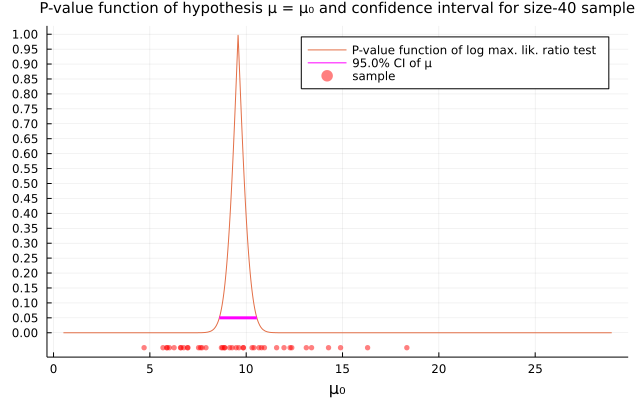

ci = confint_loglikrat(x; α) = [8.60570034537923, 10.553293008337757]


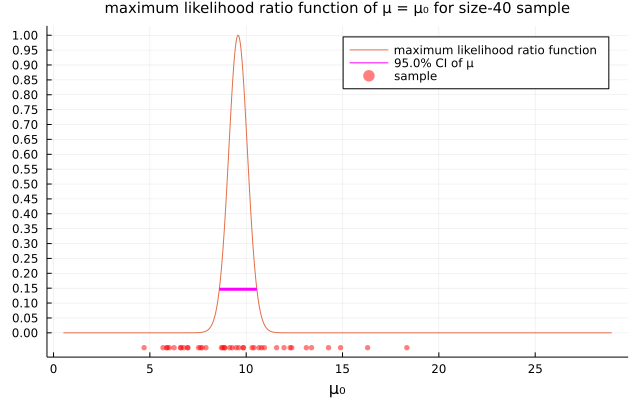

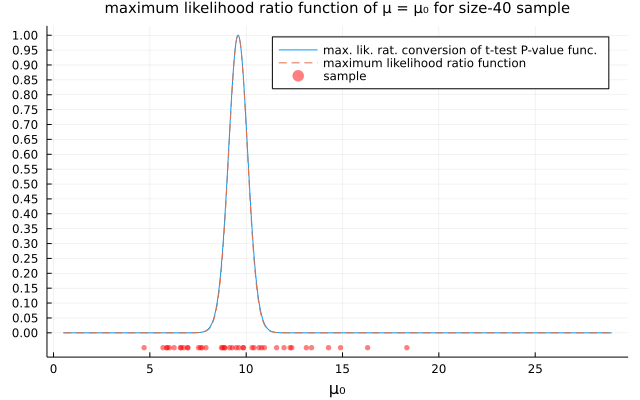

pri = (μ₀ = 0, λ₀ = 0.0002, γ = 2, θ = 0.5)
(mean(μ), mean(σ²)) = (-0.014961292809122697, 1.9931632786693623)


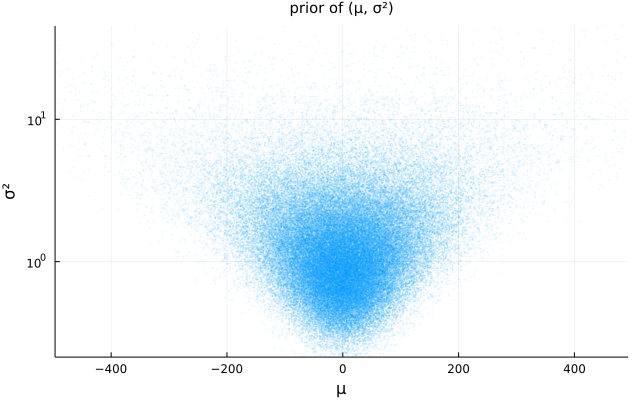

post = baysian_update(x; pri) = (μ₀ = 9.579448779614596, λ₀ = 40.0002, γ = 22.0, θ = 0.005258693400081845)
(mean(μ), mean(σ²)) = (9.576663078092484, 9.073877152478888)


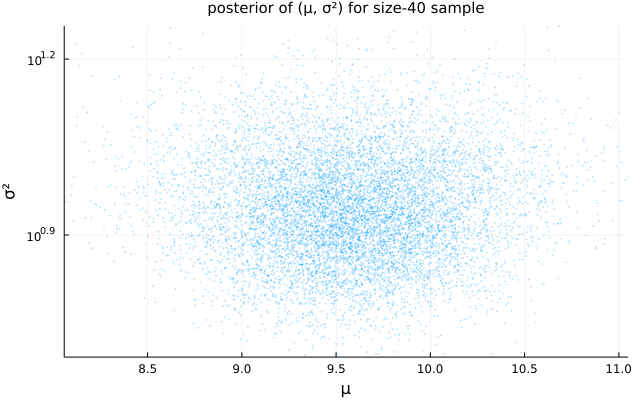

post_μ = dist_μ(; pri = post) = LocationScale{Float64, Continuous, TDist{Float64}}(
μ: 9.579448779614596
σ: 0.46485622689728046
ρ: TDist{Float64}(ν=44.0)
)

ci = credint(x; α, pri) = [8.642592613147544, 10.516304946081648]


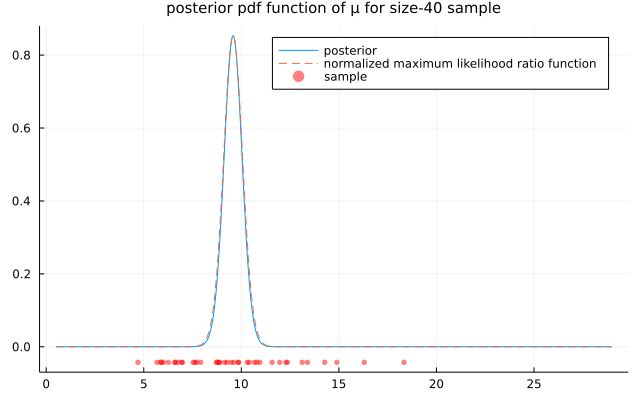

In [11]:
plot_etc(; dist_true=Gamma(10, 1), m=40, ms=3, seed=4649373)

mean(dist_true) = 10.0
var(dist_true) = 10.0
mean(x) = 9.73660236221831
var(x) = 9.366625205018313


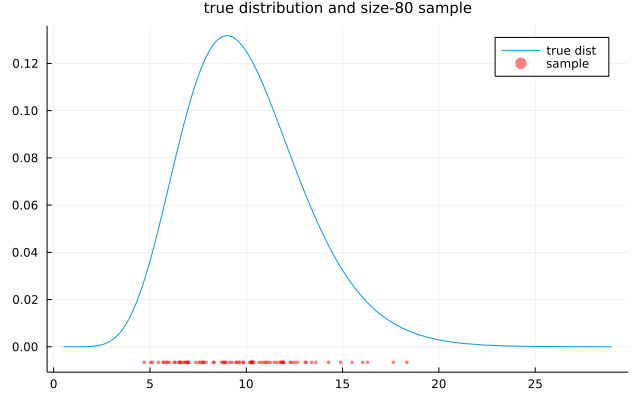

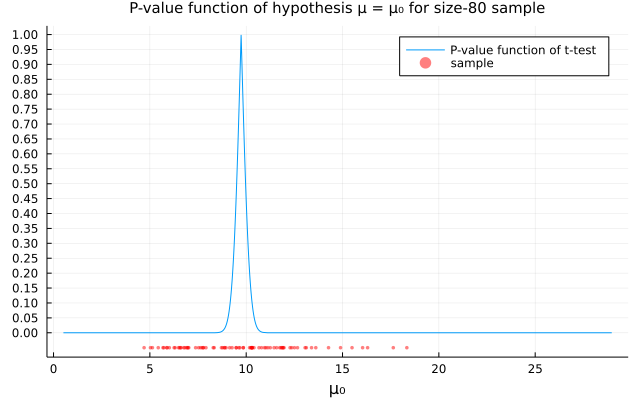

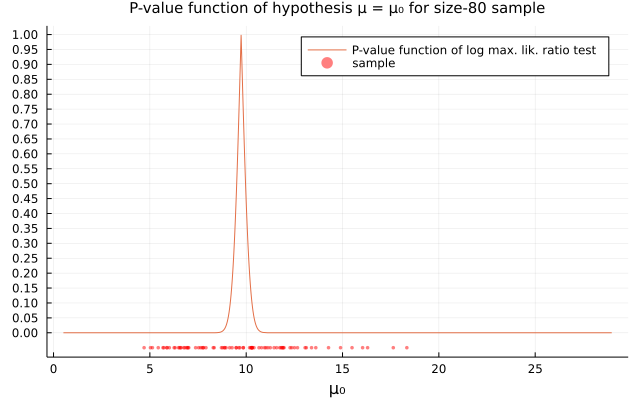

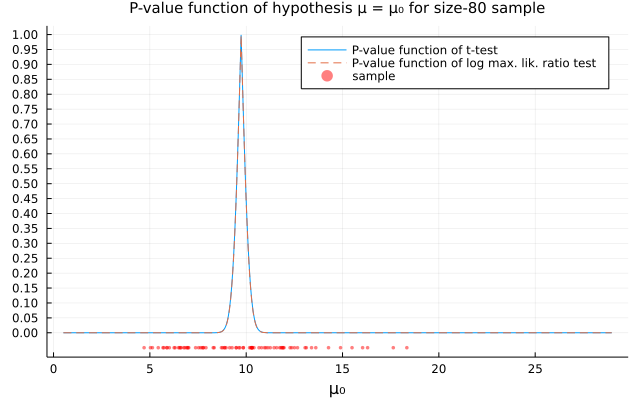

ci = confint(x; α) = [9.055522724475283, 10.417681999961337]


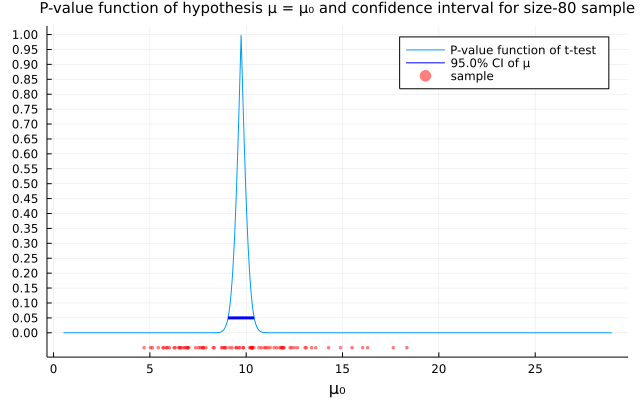

ci = confint_loglikrat(x; α) = [9.06207806785723, 10.411126656579377]


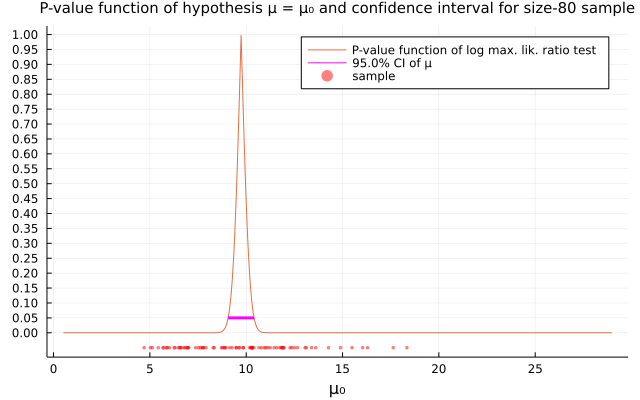

ci = confint_loglikrat(x; α) = [9.06207806785723, 10.411126656579377]


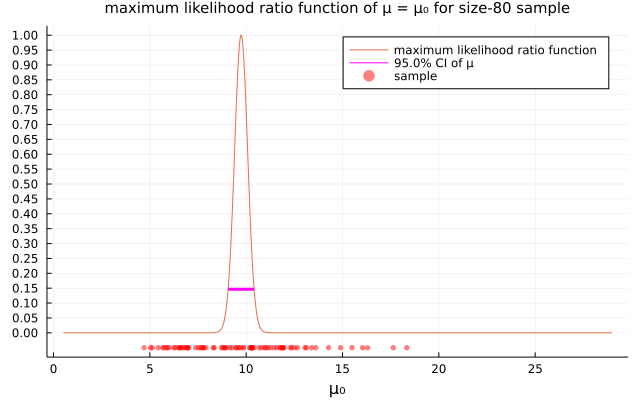

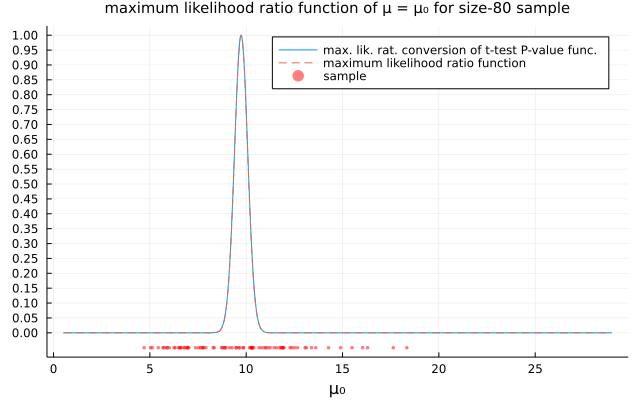

pri = (μ₀ = 0, λ₀ = 0.0002, γ = 2, θ = 0.5)
(mean(μ), mean(σ²)) = (-0.014957335852271367, 1.9931275721540362)


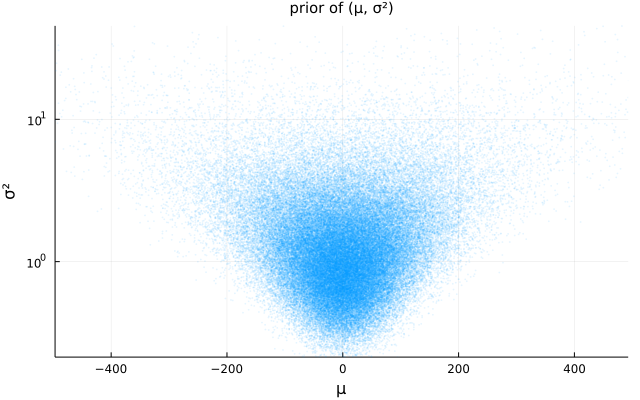

post = baysian_update(x; pri) = (μ₀ = 9.736578020773257, λ₀ = 80.0002, γ = 42.0, θ = 0.0026882358111649353)
(mean(μ), mean(σ²)) = (9.73448658533595, 9.086658421995168)


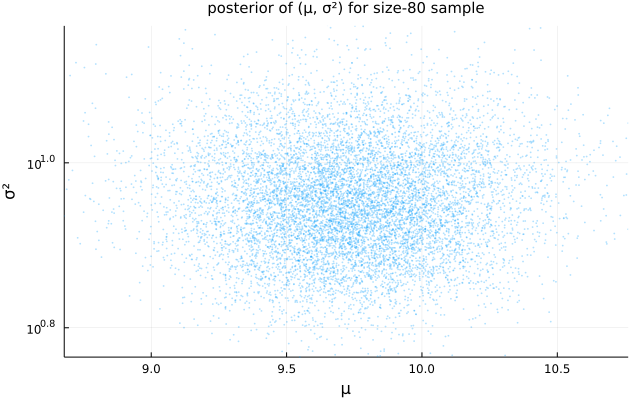

post_μ = dist_μ(; pri = post) = LocationScale{Float64, Continuous, TDist{Float64}}(
μ: 9.736578020773257
σ: 0.3327332004191199
ρ: TDist{Float64}(ν=84.0)
)

ci = credint(x; α, pri) = [9.074901561896029, 10.398254479650484]


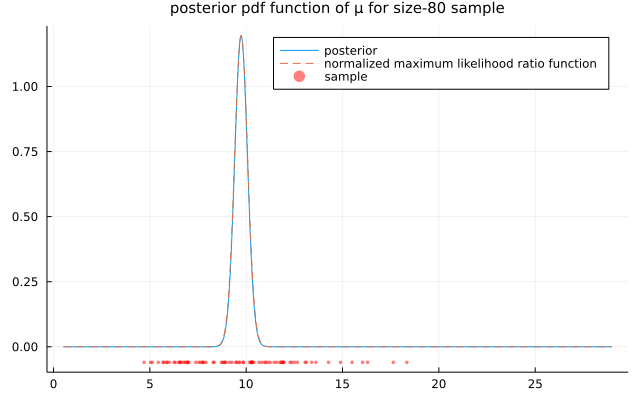

In [12]:
plot_etc(; dist_true=Gamma(10, 1), m=80, ms=2, seed=4649373)

mean(dist_true) = 10.0
var(dist_true) = 10.0
mean(x) = 10.238949304243299
var(x) = 14.672034716535684


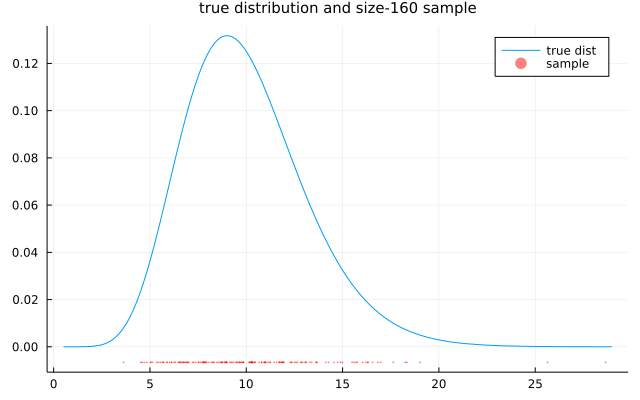

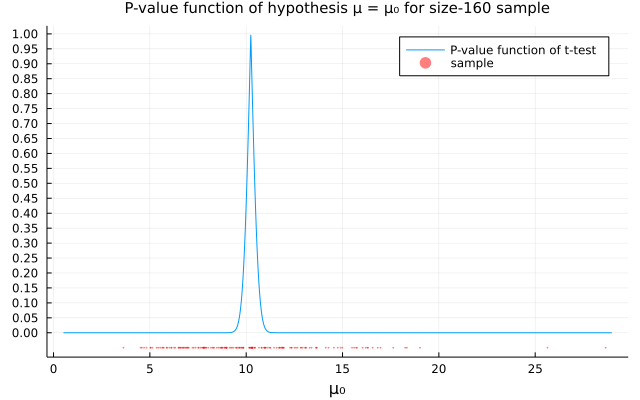

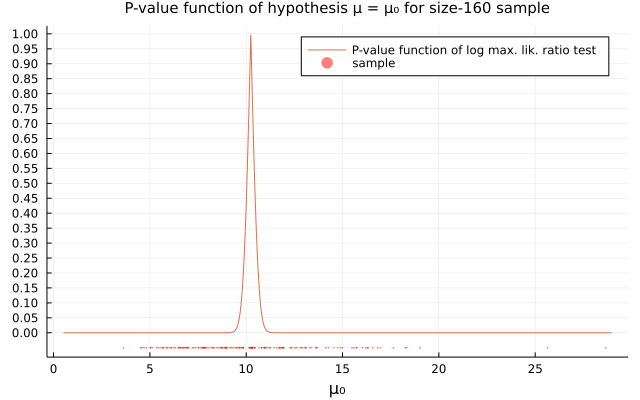

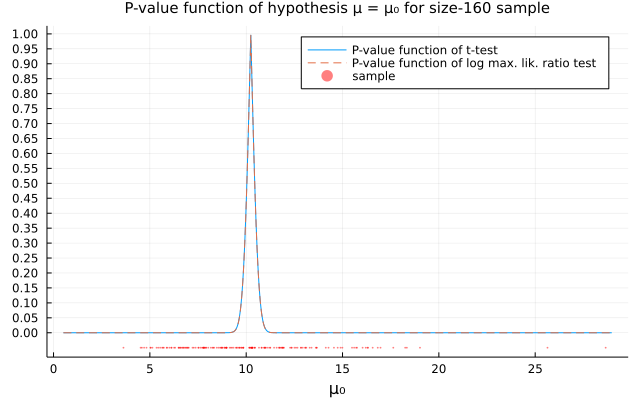

ci = confint(x; α) = [9.64088008830186, 10.837018520184738]


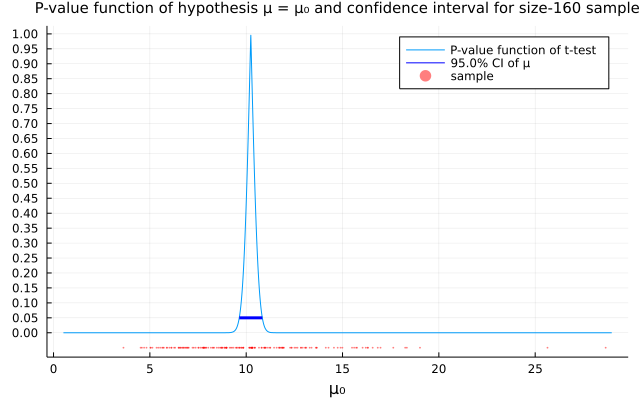

ci = confint_loglikrat(x; α) = [9.643720669380585, 10.834177939106027]


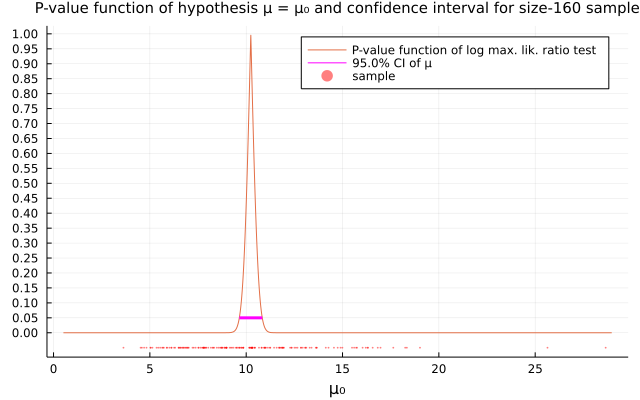

ci = confint_loglikrat(x; α) = [9.643720669380585, 10.834177939106027]


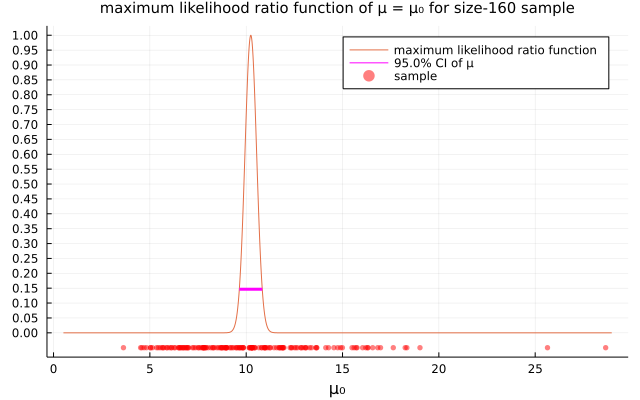

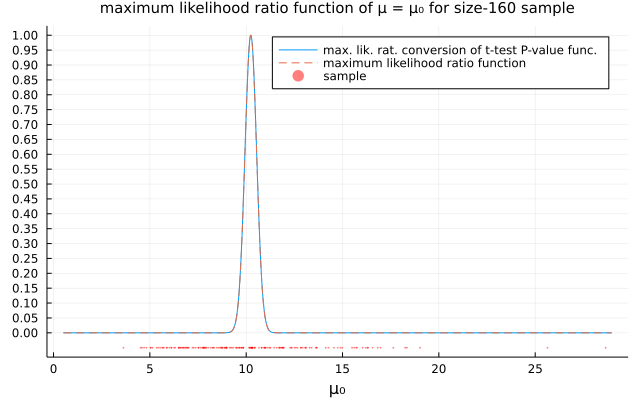

pri = (μ₀ = 0, λ₀ = 0.0002, γ = 2, θ = 0.5)
(mean(μ), mean(σ²)) = (-0.021987356924637196, 1.992953400841214)


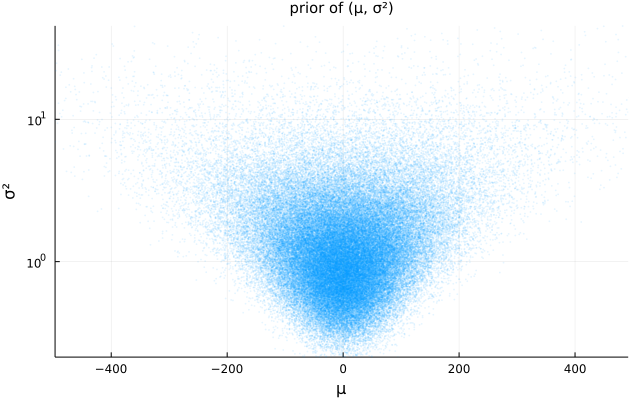

post = baysian_update(x; pri) = (μ₀ = 10.238936505572667, λ₀ = 160.0002, γ = 82.0, θ = 0.0008558439963394131)
(mean(μ), mean(σ²)) = (10.237310118505537, 14.447065912296065)


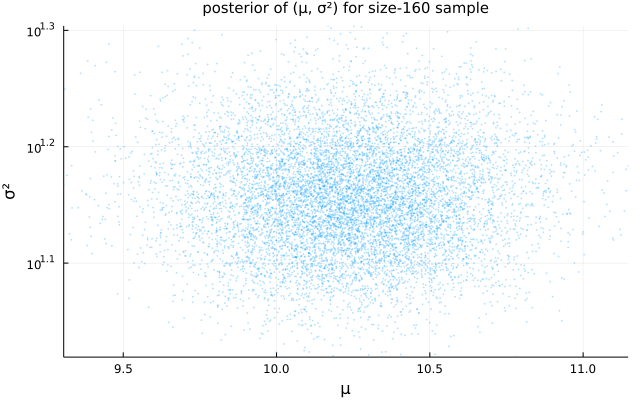

post_μ = dist_μ(; pri = post) = LocationScale{Float64, Continuous, TDist{Float64}}(
μ: 10.238936505572667
σ: 0.2984252090771349
ρ: TDist{Float64}(ν=164.0)
)

ci = credint(x; α, pri) = [9.64968561194207, 10.828187399203264]


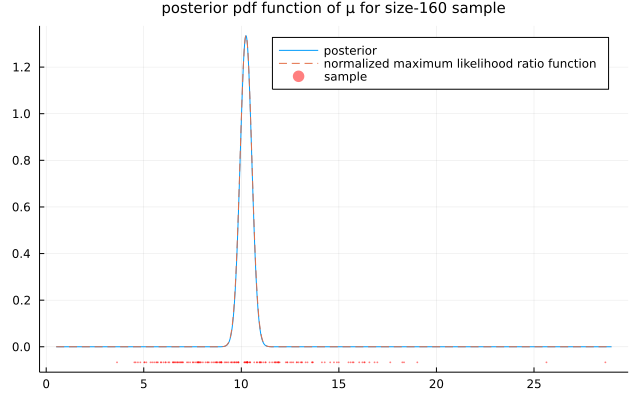

In [13]:
plot_etc(; dist_true=Gamma(10, 1), m=160, ms=1, seed=4649373)

mean(dist_true) = 10.0
var(dist_true) = 10.0
mean(x) = 10.159962619271074
var(x) = 12.661776312987087


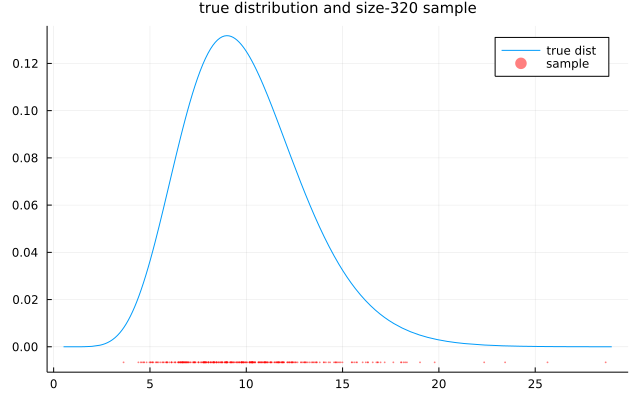

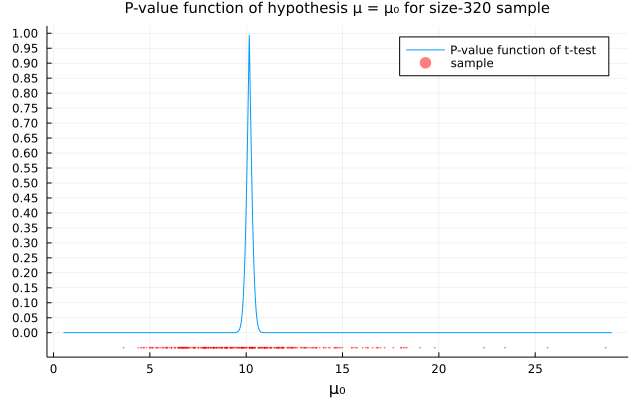

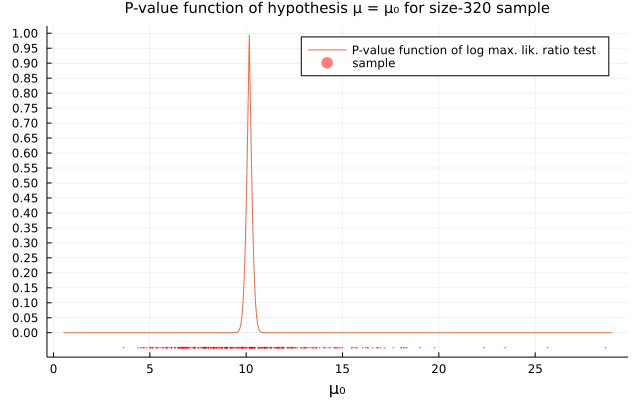

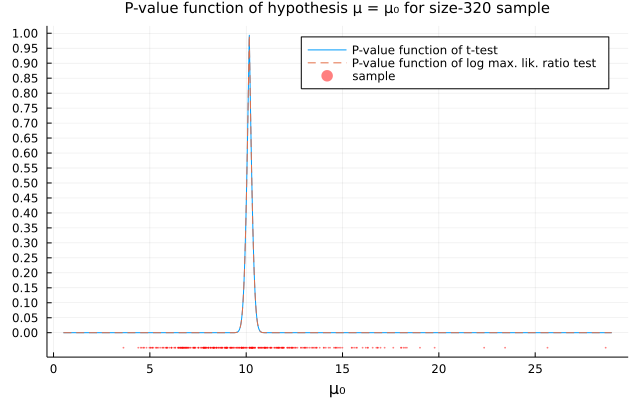

ci = confint(x; α) = [9.768607280655948, 10.5513179578862]


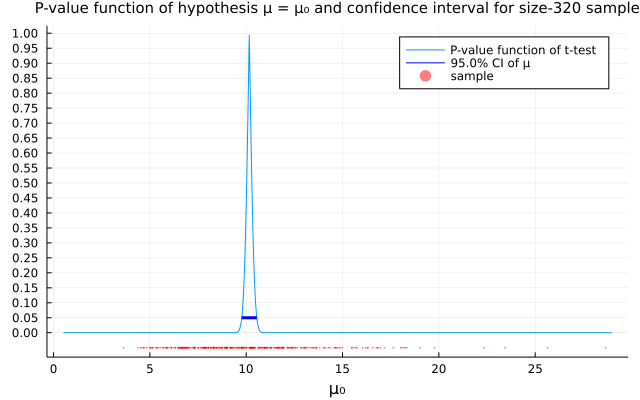

ci = confint_loglikrat(x; α) = [9.769530574767682, 10.550394663774467]


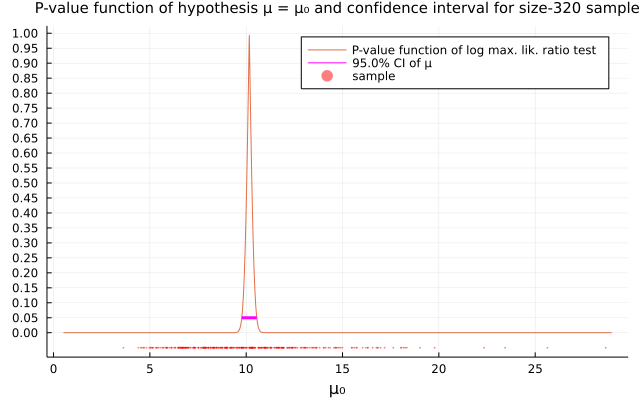

ci = confint_loglikrat(x; α) = [9.769530574767682, 10.550394663774467]


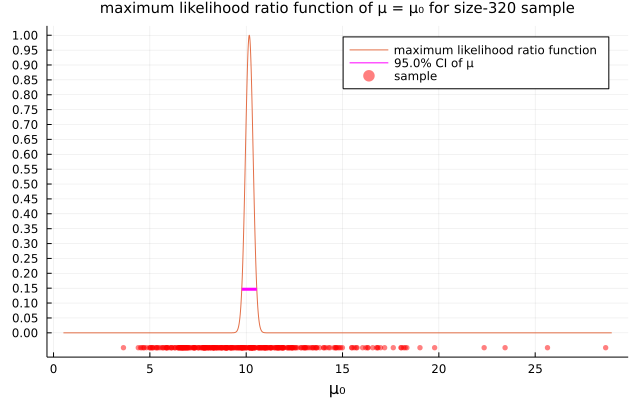

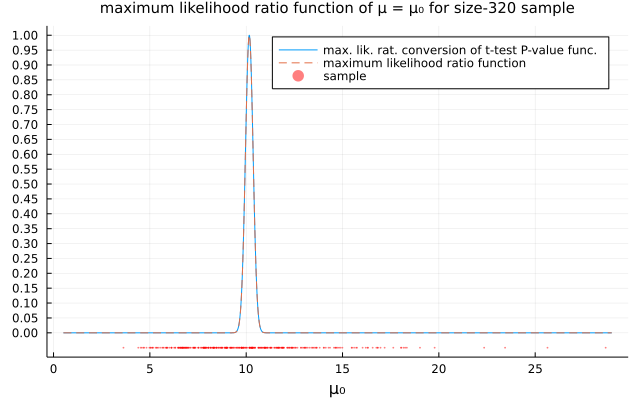

pri = (μ₀ = 0, λ₀ = 0.0002, γ = 2, θ = 0.5)
(mean(μ), mean(σ²)) = (-0.020481286014493172, 1.992440007371495)


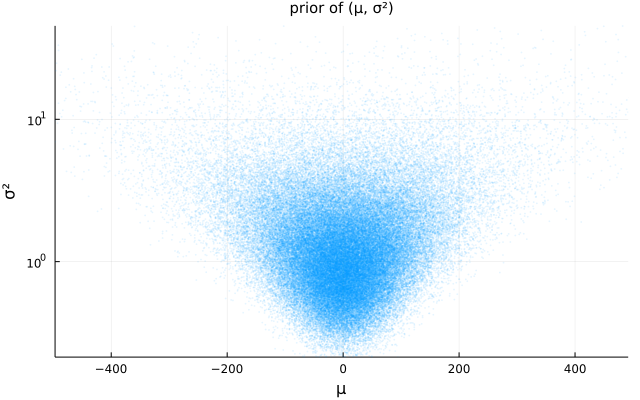

post = baysian_update(x; pri) = (μ₀ = 10.159956269298405, λ₀ = 320.0002, γ = 162.0, θ = 0.0004946665927489407)
(mean(μ), mean(σ²)) = (10.15939673764386, 12.569589677125201)


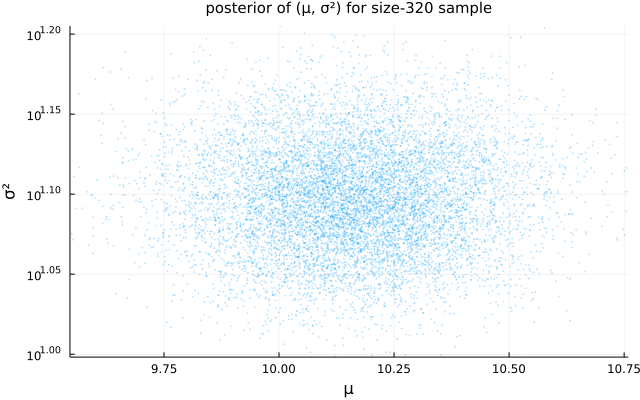

post_μ = dist_μ(; pri = post) = LocationScale{Float64, Continuous, TDist{Float64}}(
μ: 10.159956269298405
σ: 0.19747452469520832
ρ: TDist{Float64}(ν=324.0)
)

ci = credint(x; α, pri) = [9.771462114780288, 10.548450423816522]


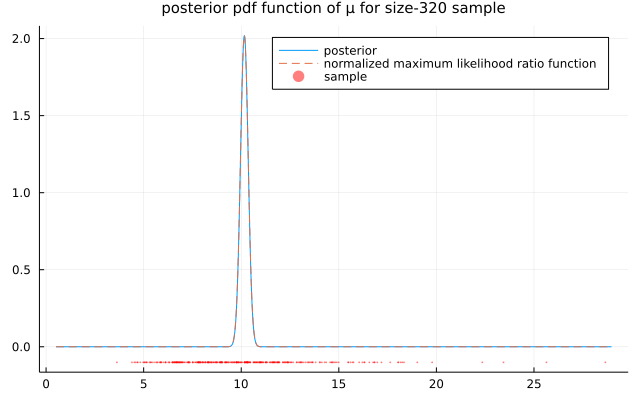

In [14]:
plot_etc(; dist_true=Gamma(10, 1), m=320, ms=1, seed=4649373)

mean(dist_true) = 10.0
var(dist_true) = 10.0
mean(x) = 10.202442914009827
var(x) = 11.005589278544607


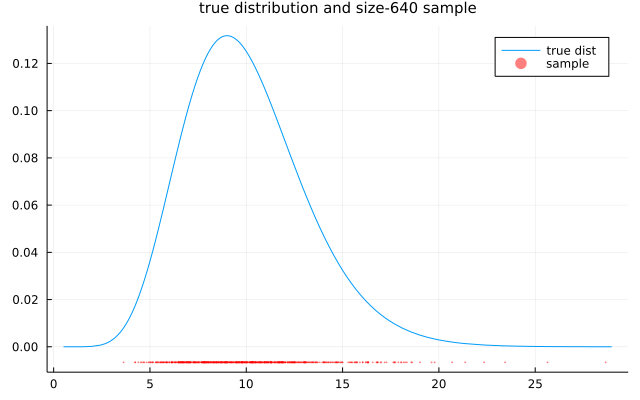

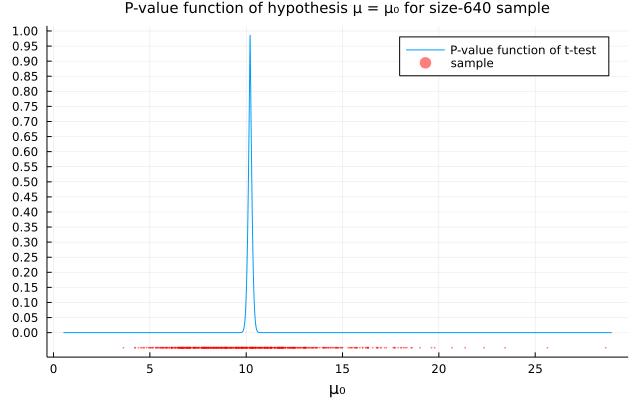

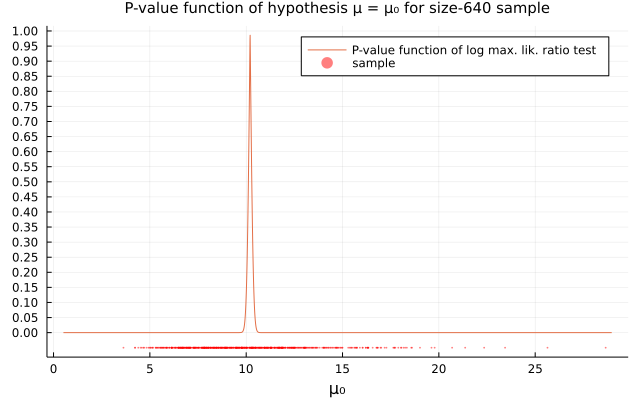

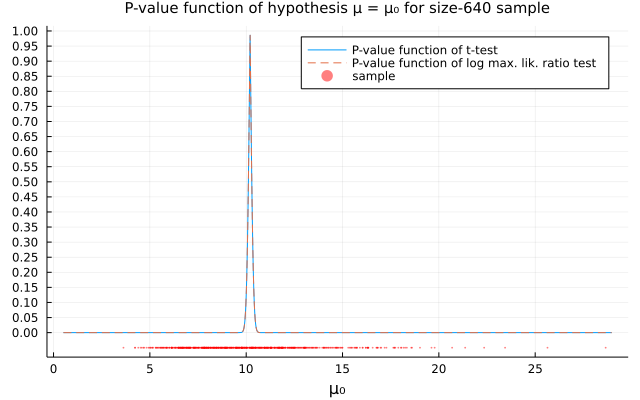

ci = confint(x; α) = [9.944936454156132, 10.459949373863523]


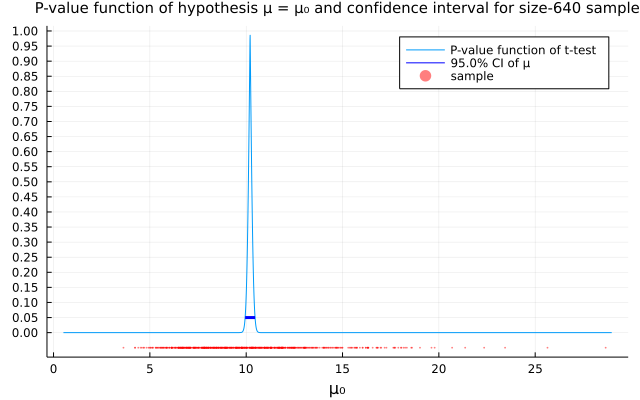

ci = confint_loglikrat(x; α) = [9.945239213979908, 10.459646614039961]


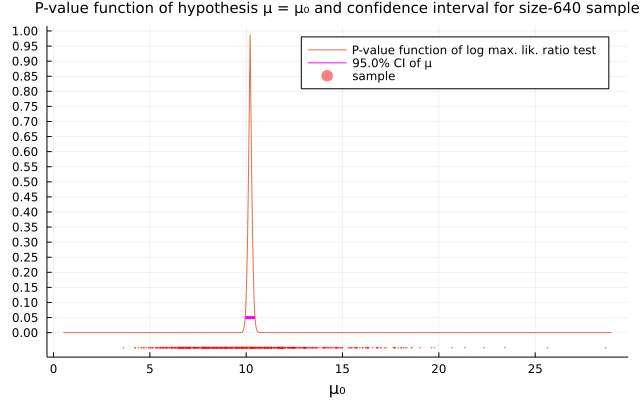

ci = confint_loglikrat(x; α) = [9.945239213979908, 10.459646614039961]


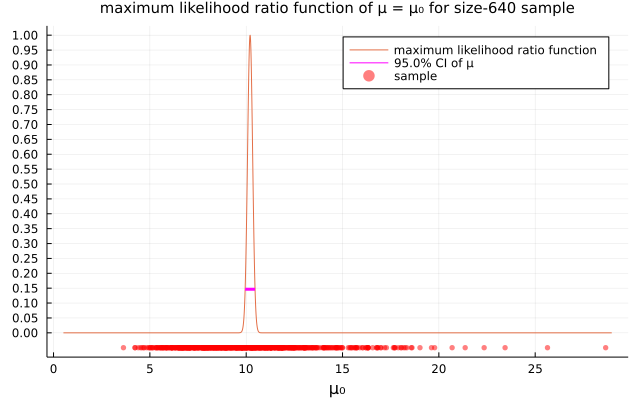

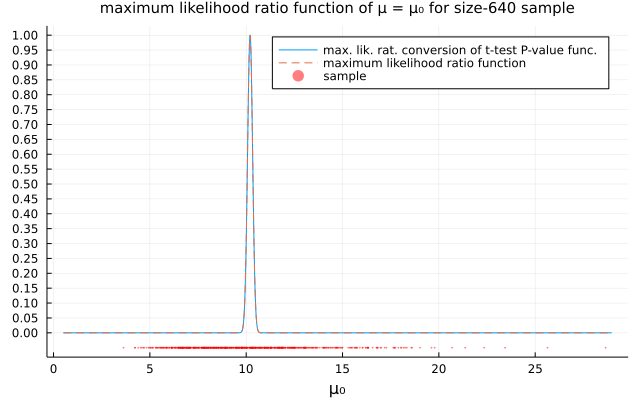

pri = (μ₀ = 0, λ₀ = 0.0002, γ = 2, θ = 0.5)
(mean(μ), mean(σ²)) = (-0.03360871345595751, 1.9931280902407604)


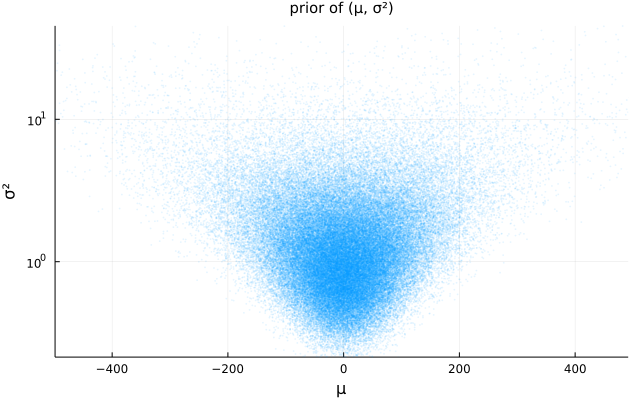

post = baysian_update(x; pri) = (μ₀ = 10.202439725747414, λ₀ = 640.0002, γ = 322.0, θ = 0.0002842284867023483)
(mean(μ), mean(σ²)) = (10.201874530524169, 10.967705388199956)


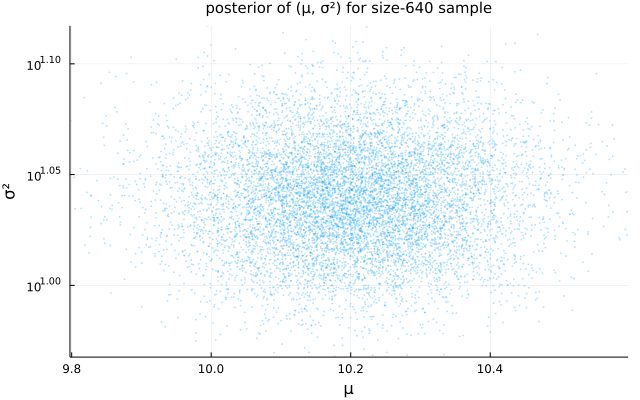

post_μ = dist_μ(; pri = post) = LocationScale{Float64, Continuous, TDist{Float64}}(
μ: 10.202439725747414
σ: 0.13066167097982814
ρ: TDist{Float64}(ν=644.0)
)

ci = credint(x; α, pri) = [9.945865354001375, 10.459014097493453]


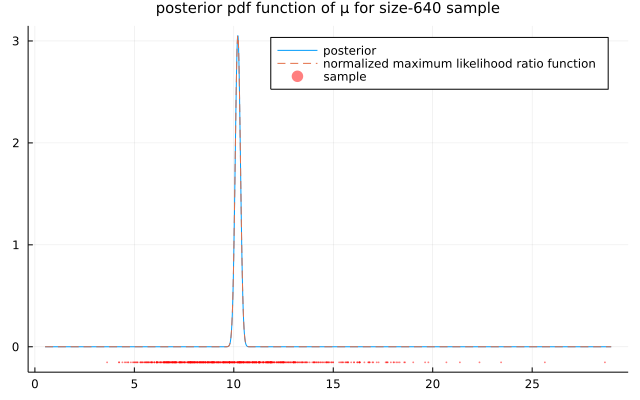

In [15]:
plot_etc(; dist_true=Gamma(10, 1), m=640, ms=1, seed=4649373)

In [16]:
function plot_ttest(;
        dist_true = Gamma(10, 1),
        m = 10,
        μ_0 = 0, sμ² = 100^2, γ = 1.5, θ = 2,
        pri = (μ₀ = 0, λ₀ = 1/(γ*θ*(1 - 1/γ)*sμ²), γ, θ),
        seed = 4649373
    )
    isnothing(seed) || Random.seed!(seed)
    x = rand(dist_true, m)

    μ, σ = mean(dist_true), std(dist_true)
    a, b = max(minimum(dist_true), μ - 5σ), min(maximum(dist_true), μ + 6σ)

    post = baysian_update(x; pri)
    post_μ = dist_μ(; pri=post)
    pred_xnew = dist_x(; pri=post)
    μ_xnew = mean(pred_xnew)
    
    @show dist_true
    @show m
    @show mean(dist_true) var(dist_true)
    @show mean(x) var(x)
    @show mean(dist_pred(x)) var(dist_pred(x))
    @show mean(pred_xnew) var(pred_xnew)
    
    P1 = plot(μ -> pvalue(x, μ), a, b; label="t-test")
    plot!(μ -> pvalue_bayes(x, μ), a, b; label="Bayesian", ls=:dash)
    scatter!(x, fill(-0.05, length(x));
        label="sample", ms=1.5, msc=:auto, alpha=0.5, c=:red)
    title!("P-value functions")

    P2 = plot(μ -> pdf(confdist(x), μ), a, b; label="t-test")
    plot!(μ -> pdf(post_μ, μ), a, b; label="Bayesian", ls=:dash)
    h = pdf(confdist(x), mode(confdist(x)))
    scatter!(x, fill(-0.05h, length(x));
        label="sample", ms=1.5, msc=:auto, alpha=0.5, c=:red)
    title!("parameter distributions")

    P3 = plot(xnew -> pvalue_pred(x, xnew), a, b; label="t-test")
    plot!(xnew -> 2ccdf(pred_xnew, μ_xnew + abs(xnew - μ_xnew)), a, b;
        label="Bayesian", ls=:dash)
    scatter!(x, fill(-0.05, length(x));
        label="sample", ms=1.5, msc=:auto, alpha=0.5, c=:red)
    title!("prediction P-value functions")

    P4 = plot(xnew -> pdf(dist_pred(x), xnew), a, b; label="t-test")
    plot!(xnew -> pdf(pred_xnew, xnew), a, b; label="Bayesian", ls=:dash)
    plot!(dist_true, a, b; label="true dist", ls=:dot, c=:black)
    h = pdf(dist_pred(x), mode(dist_pred(x)))
    scatter!(x, fill(-0.05h, length(x));
        label="sample", ms=1.5, msc=:auto, alpha=0.5, c=:red)
    title!("prediction distributions")

    plot(P1, P2, P3, P4; size=(800, 500), layout=(2, 2))
    plot!(; plot_title="P-value functions, etc. \
        for size-$m sample of $(dist_true)")
end

plot_ttest (generic function with 1 method)

dist_true = Gamma{Float64}(α=10.0, θ=1.0)
m = 10
mean(dist_true) = 10.0
var(dist_true) = 10.0
mean(x) = 9.560365886166755
var(x) = 9.102142426957071
mean(dist_pred(x)) = 9.560365886166755
var(dist_pred(x)) = 12.87303000383929
mean(pred_xnew) = 9.560270283463922
var(pred_xnew) = 8.29283464220812


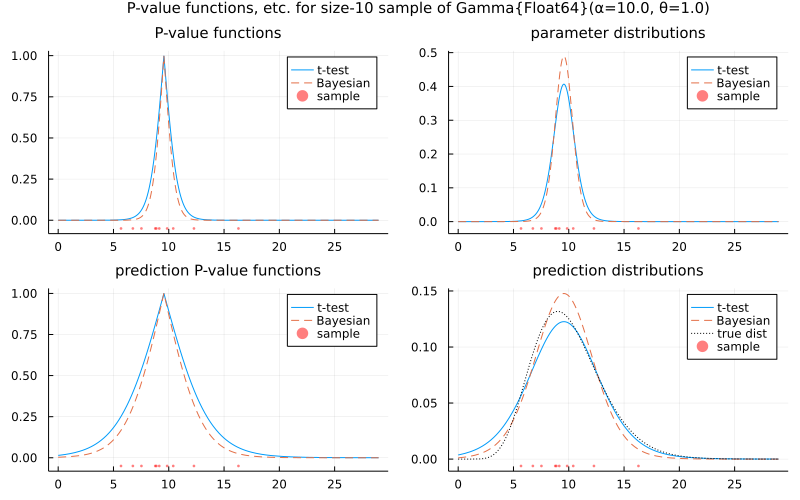

In [17]:
plot_ttest(dist_true=Gamma(10, 1), m=10, seed=4649373)

dist_true = Gamma{Float64}(α=10.0, θ=1.0)
m = 20
mean(dist_true) = 10.0
var(dist_true) = 10.0
mean(x) = 9.169403594454309
var(x) = 6.925622020000762
mean(dist_pred(x)) = 9.169403594454309
var(dist_pred(x)) = 8.127421135236187
mean(pred_xnew) = 9.16935774766557
var(pred_xnew) = 6.62975972820347


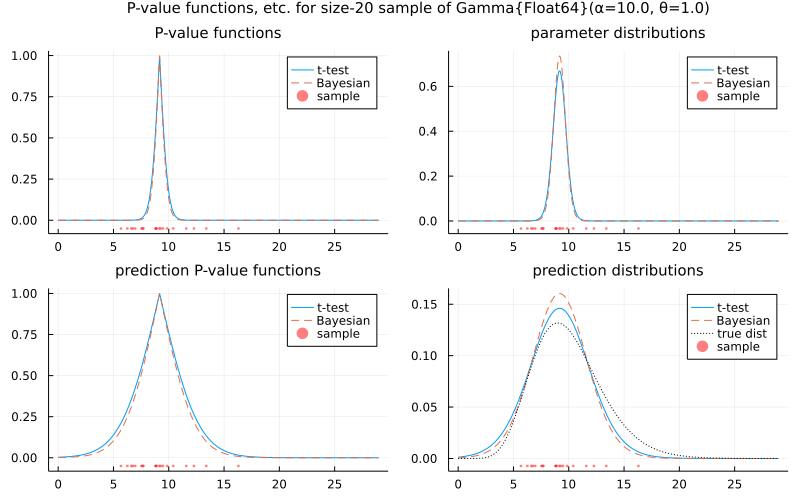

In [18]:
plot_ttest(dist_true=Gamma(10, 1), m=20, seed=4649373)

dist_true = Gamma{Float64}(α=10.0, θ=1.0)
m = 30
mean(dist_true) = 10.0
var(dist_true) = 10.0
mean(x) = 9.031727755767667
var(x) = 7.009850017505368
mean(dist_pred(x)) = 9.031727755767667
var(dist_pred(x)) = 7.780068105848552
mean(pred_xnew) = 9.031697650108834
var(pred_xnew) = 6.8097928574695885


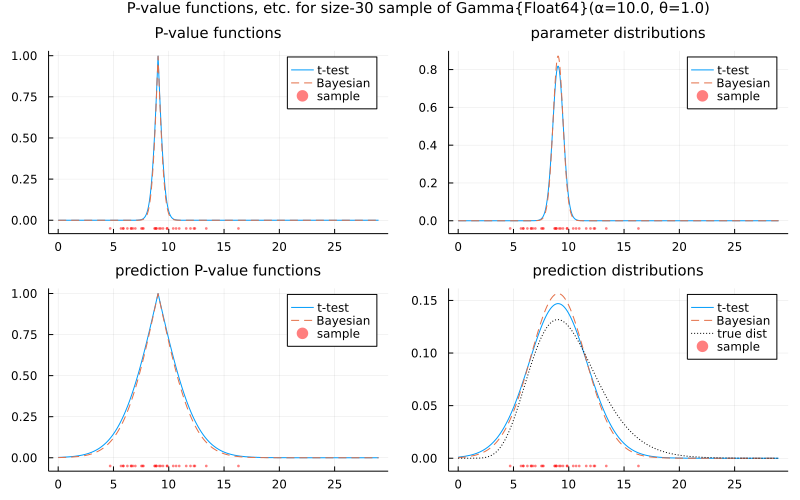

In [19]:
plot_ttest(dist_true=Gamma(10, 1), m=30, seed=4649373)

dist_true = Gamma{Float64}(α=10.0, θ=1.0)
m = 40
mean(dist_true) = 10.0
var(dist_true) = 10.0
mean(x) = 9.579496676858493
var(x) = 9.648827100253905
mean(dist_pred(x)) = 9.579496676858493
var(dist_pred(x)) = 10.42464495493648
mean(pred_xnew) = 9.579472728176674
var(pred_xnew) = 9.432835263893997


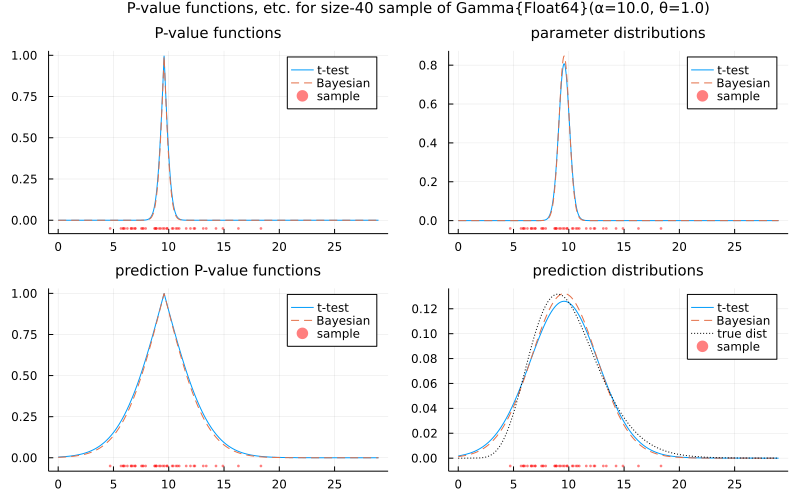

In [20]:
plot_ttest(dist_true=Gamma(10, 1), m=40, seed=4649373)

dist_true = Gamma{Float64}(α=10.0, θ=1.0)
m = 80
mean(dist_true) = 10.0
var(dist_true) = 10.0
mean(x) = 9.73660236221831
var(x) = 9.366625205018313
mean(dist_pred(x)) = 9.73660236221831
var(dist_pred(x)) = 9.730038098524703
mean(pred_xnew) = 9.73659019148057
var(pred_xnew) = 9.262160748655003


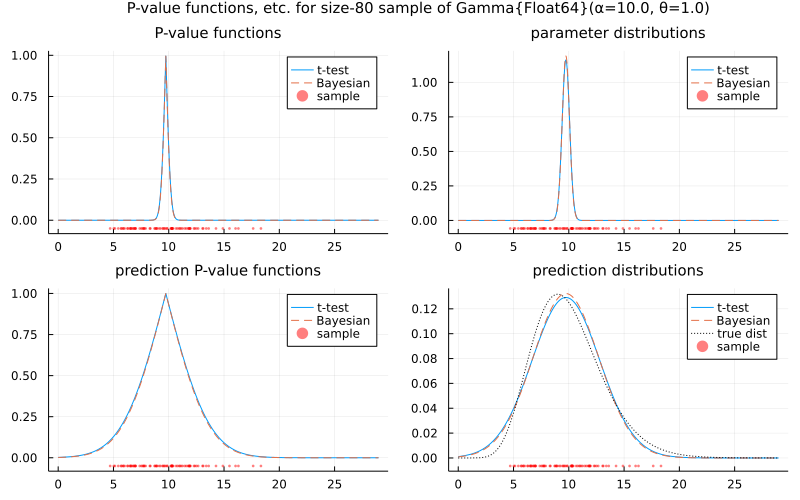

In [21]:
plot_ttest(dist_true=Gamma(10, 1), m=80, seed=4649373)

dist_true = Gamma{Float64}(α=10.0, θ=1.0)
m = 160
mean(dist_true) = 10.0
var(dist_true) = 10.0
mean(x) = 10.238949304243299
var(x) = 14.672034716535684
mean(dist_pred(x)) = 10.238949304243299
var(dist_pred(x)) = 14.951807989991918
mean(pred_xnew) = 10.238942904903983
var(pred_xnew) = 14.58664996544301


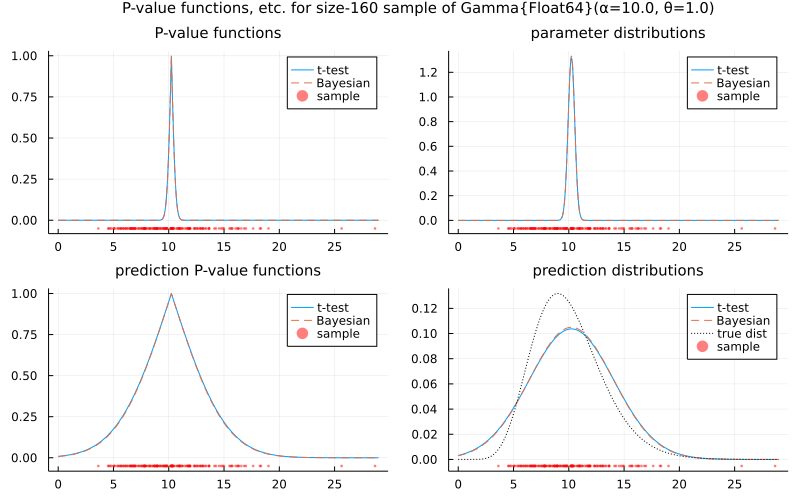

In [22]:
plot_ttest(dist_true=Gamma(10, 1), m=160, seed=4649373)

dist_true = Gamma{Float64}(α=10.0, θ=1.0)
m = 320
mean(dist_true) = 10.0
var(dist_true) = 10.0
mean(x) = 10.159962619271074
var(x) = 12.661776312987087
mean(dist_pred(x)) = 10.159962619271074
var(dist_pred(x)) = 12.781479028722051
mean(pred_xnew) = 10.159959444283748
var(pred_xnew) = 12.625365507470512


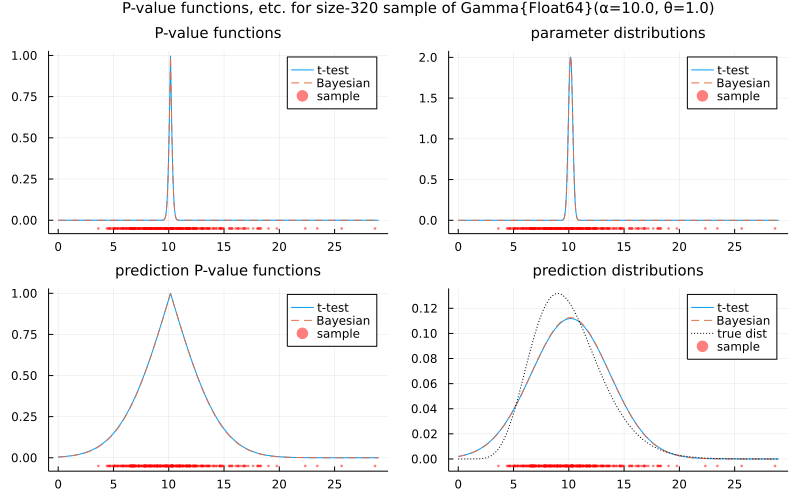

In [23]:
plot_ttest(dist_true=Gamma(10, 1), m=320, seed=4649373)

dist_true = Gamma{Float64}(α=10.0, θ=1.0)
m = 640
mean(dist_true) = 10.0
var(dist_true) = 10.0
mean(x) = 10.202442914009827
var(x) = 11.005589278544607
mean(dist_pred(x)) = 10.202442914009827
var(dist_pred(x)) = 11.057393943540502
mean(pred_xnew) = 10.202441319878371
var(pred_xnew) = 10.989971806653148


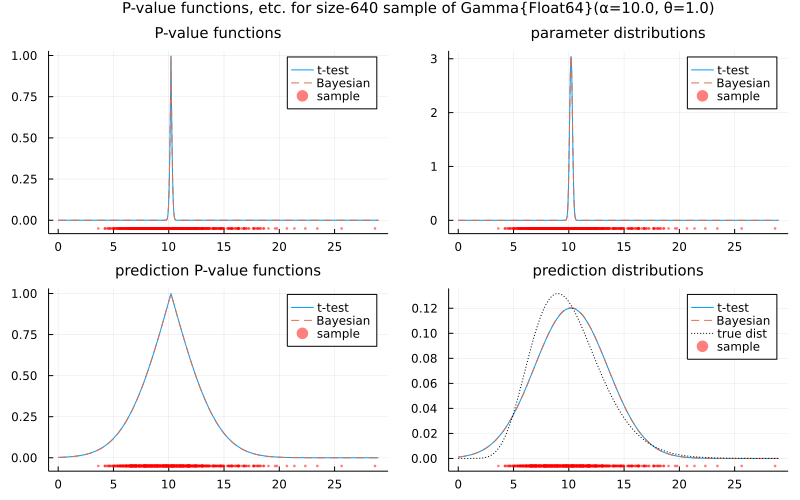

In [24]:
plot_ttest(dist_true=Gamma(10, 1), m=640, seed=4649373)